In [3]:
import numpy as np

import datetime as dt
from datetime import timedelta
import scipy as sp
import scipy.ndimage
import matplotlib.tri as tri
from scipy.ndimage import zoom

from netCDF4 import Dataset

from scipy import stats

import csv
import os

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import xarray as xr
from scipy.interpolate import UnivariateSpline



In [45]:
indexes = np.arange(365)
year_in_days = 365

monthly_slices = {}
for month in range(1, 13):
    start_index = (month - 1) * 30  
    end_index = start_index + 30 - 1
    if month == 12:
        end_index = 364
    monthly_slices[month] = indexes[start_index:end_index + 1]

# в monthly_slices[month] содержатся срезы данных для каждого месяца
# monthly_slices[1]+5*year_in_days


In [5]:
def save(name='', fmt='png'):
    pwd = os.getcwd()
#    iPath = './pictures/{}'.format(fmt)
    iPath = '.'
    if not os.path.exists(iPath):
        os.mkdir(iPath)
    os.chdir(iPath)
    plt.savefig('{}.{}'.format(name, fmt), fmt='png')
    os.chdir(pwd)
    #plt.close()

In [10]:
#   INPUT PARAMETERS

# Регион исследования "Калининградская область"
# 17–24E, 54–56N

# Данные реанализа ERA-5
# https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era-interim

# Метка региона для выходных файлов
reg_name='KLNG'

# кол-во точек по долготе и широте
ilon=29
ilat=9

# координаты углов, выбранного региона
ll_lon=17
ll_lat=54
ur_lon=24
ur_lat=56
#
OUTPATH=''
path = os.getcwd()
new_path = os.path.dirname(path)
in_file=new_path + '/data/' + 'ERA5_uv10m_Kaliningrad_wo29feb_daily.nc'
print(in_file)
# in_file_1980=INPATH + 'ERA5_uv10m_Kaliningrad_wo29feb_1980.nc'

/Users/nikolayborovets/Desktop/FALT_MIPT/FloatingUniversity/offshore_energy_calculation/data/ERA5_uv10m_Kaliningrad_wo29feb_daily.nc


In [11]:
ds_bal = xr.open_dataset(in_file, decode_times=False)
# Decoding time
ds_bal = xr.decode_cf(ds_bal)

In [13]:
# Считываем входные данные, формат  NetCDF

ncin=Dataset(in_file)
u10_daily=ncin.variables['ucomp10'][:]
v10_daily=ncin.variables['vcomp10'][:]
lons=ncin.variables['lon'][:]
lats=ncin.variables['lat'][:]
time=ncin.variables['time'][:]
ncin.close()

In [14]:
print(u10_daily.shape, v10_daily.shape, lons.shape, lats.shape, time.shape)
# u10_daily.shape
# v10_daily.shape
#данные с 1979 по 2022

(16060, 9, 29) (16060, 9, 29) (29,) (9,) (16060,)


In [15]:
len(u10_daily[:, 3, 3])

16060

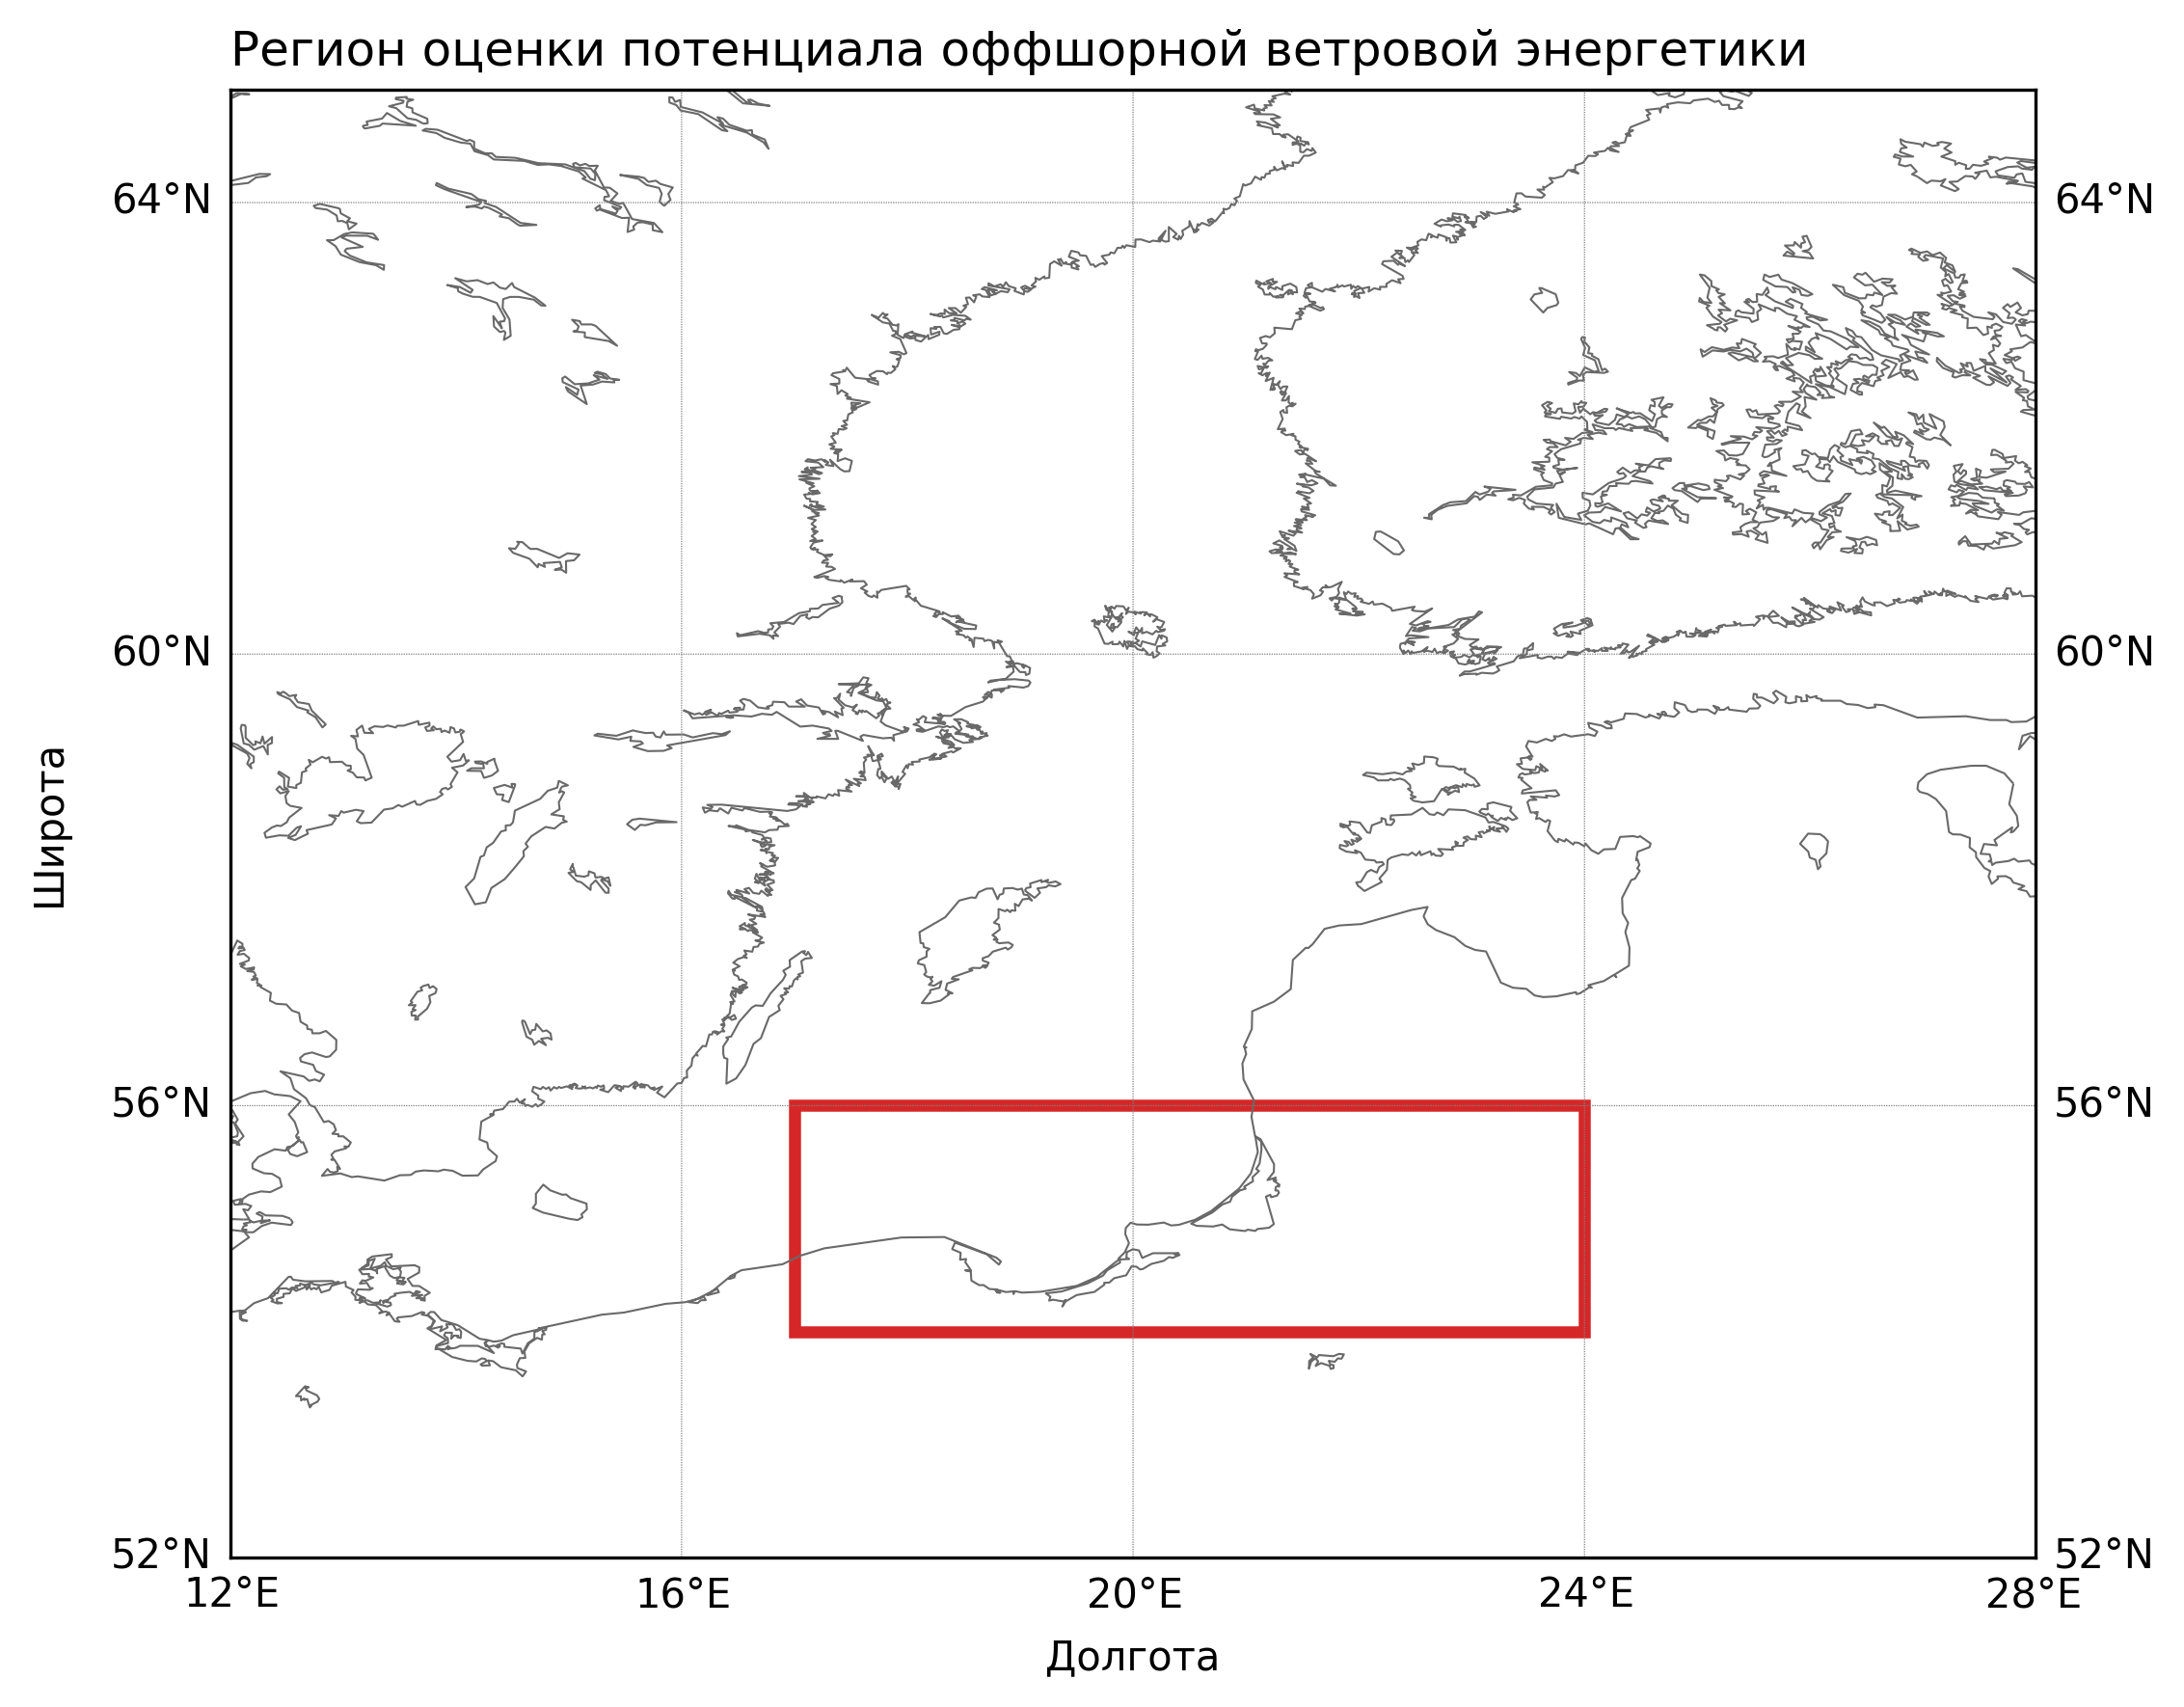

In [16]:
# Регион исследования "Калининградская область"
# 17–24E, 54–56N

fig=plt.figure(figsize=(10,6),dpi=300)

ax1=fig.add_subplot(1,1,1,label='1')

m1=Basemap(ax=ax1,projection='cyl',llcrnrlon=12,llcrnrlat=52,urcrnrlon=28,urcrnrlat=65,resolution='i')

x9,y9 = m1(ll_lon,54)
x10,y10 = m1(ur_lon,54)
x11,y11 = m1(ur_lon,56)
x12,y12 = m1(ll_lon,56)
poly = Polygon([(x9,y9),(x10,y10),(x11,y11),(x12,y12)],facecolor='None',edgecolor='tab:red',linewidth=3)
plt.gca().add_patch(poly)

m1.drawcoastlines(color="dimgrey",linewidth=0.5)
# meridians=np.arange(0,360,20)
# parallels=np.arange(40,90,10)
meridians=np.arange(0,360,4)
parallels=np.arange(40,90,4)

ax1.set_xlabel('Долгота',labelpad=20,fontstretch= 'condensed')
ax1.set_ylabel('Широта',labelpad=40,fontstretch= 'condensed')

    
m1.drawmeridians(meridians,color="grey",labels=[0, 0, 0, 1],linewidth=0.3)
m1.drawparallels(parallels,color="grey",labels=[1, 1, 0, 1],linewidth=0.3)
# ax1.scatter(19, 55,10,marker='o',color='k')


plt.title('Регион оценки потенциала оффшорной ветровой энергетики',loc='left')

plt.tight_layout()
#plt.savefig(inpath + 'region', fmt='png')

In [17]:
w10_daily=np.empty([16060,ilat,ilon])
for i in range(0,16060,1):
    w10_daily[i,:,:]=np.sqrt(u10_daily[i,:,:]**2+v10_daily[i,:,:]**2)

In [18]:
w10_daily_y=np.empty([44,365,ilat,ilon])

for i in range(0,44,1):
    w10_daily_y[i,:,:,:]=w10_daily[i*365:i*365+365,:,:]

In [19]:
np.max(w10_daily_y[:,:,3,3])

21.76143455505371

In [20]:
u10_daily_mean44=np.mean(u10_daily,axis=0)
v10_daily_mean44=np.mean(v10_daily,axis=0)

w10_mean44=np.mean(w10_daily, axis=0)
w10_min44=np.min(w10_mean44)
w10_max44=np.max(w10_mean44)

In [21]:
print(u10_daily_mean44[8][28], len(v10_daily_mean44))

print(w10_max44, w10_min44)

1.1206316 9
7.5648029342630085 3.8275655020598975


Text(0.0, 1.0, 'Средняя многолетняя скорость ветра на уровне 10 м. \n за период 1979–2022 гг. по данным ERA-5, м/с')

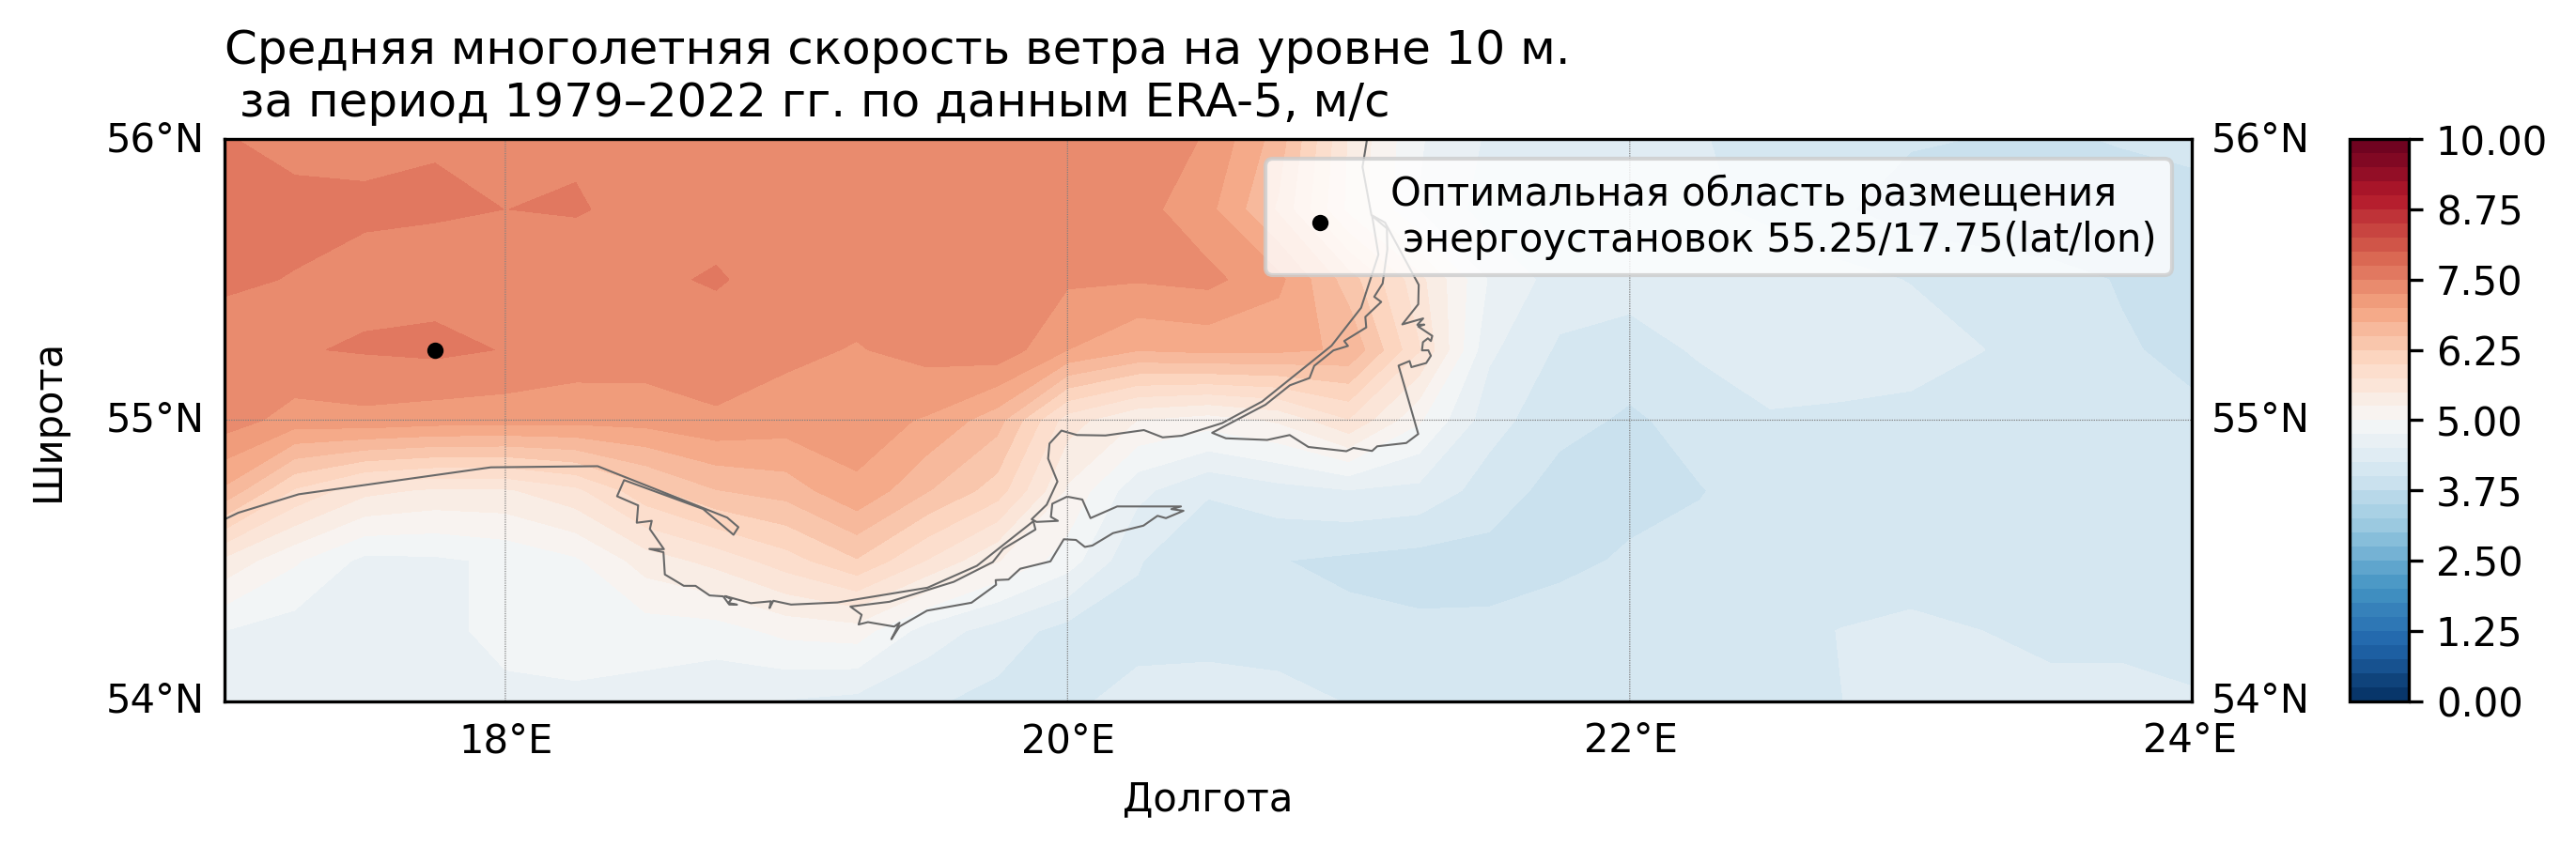

In [22]:
clevs = np.linspace(0,10,41)
fig=plt.figure(figsize=(10,6),dpi=300)

ax1=fig.add_subplot(1,1,1,label='1')

m1=Basemap(projection='cyl',ax=ax1,llcrnrlon=17,llcrnrlat=54,urcrnrlon=24,urcrnrlat=56,resolution='i')
# m1=Basemap(projection='cyl',ax=ax1,llcrnrlon=12,llcrnrlat=50,urcrnrlon=28,urcrnrlat=60,resolution='i')
x, y = m1(*np.meshgrid(lons, lats))
cs=m1.contourf(x, y,w10_mean44[:,:],clevs,cmap=plt.cm.RdBu_r)

    
m1.drawcoastlines(color="dimgrey",linewidth=0.5)
meridians=np.arange(0,360,2)
parallels=np.arange(40,80,1)

ax1.set_xlabel('Долгота',labelpad=20,fontstretch= 'condensed')
ax1.set_ylabel('Широта',labelpad=40,fontstretch= 'condensed')
    
m1.drawmeridians(meridians,color="grey",labels=[1, 1, 0, 1],linewidth=0.3)
m1.drawparallels(parallels,color="grey",labels=[1, 1, 1, 1],linewidth=0.3)
# ax1.scatter(18.75, 55.5,10,marker='o',color='r')
ax1.scatter(17.75, 55.25, 10,marker='o',color='k', label='Оптимальная область размещения\n энергоустановок 55.25/17.75(lat/lon)')
plt.legend()
    
m1.colorbar(cs,location='right',size='3%',pad='8%')
plt.title('Средняя многолетняя скорость ветра на уровне 10 м. \n за период 1979–2022 гг. по данным ERA-5, м/с',loc='left')

#plt.savefig(inpath + 'region', fmt='png')

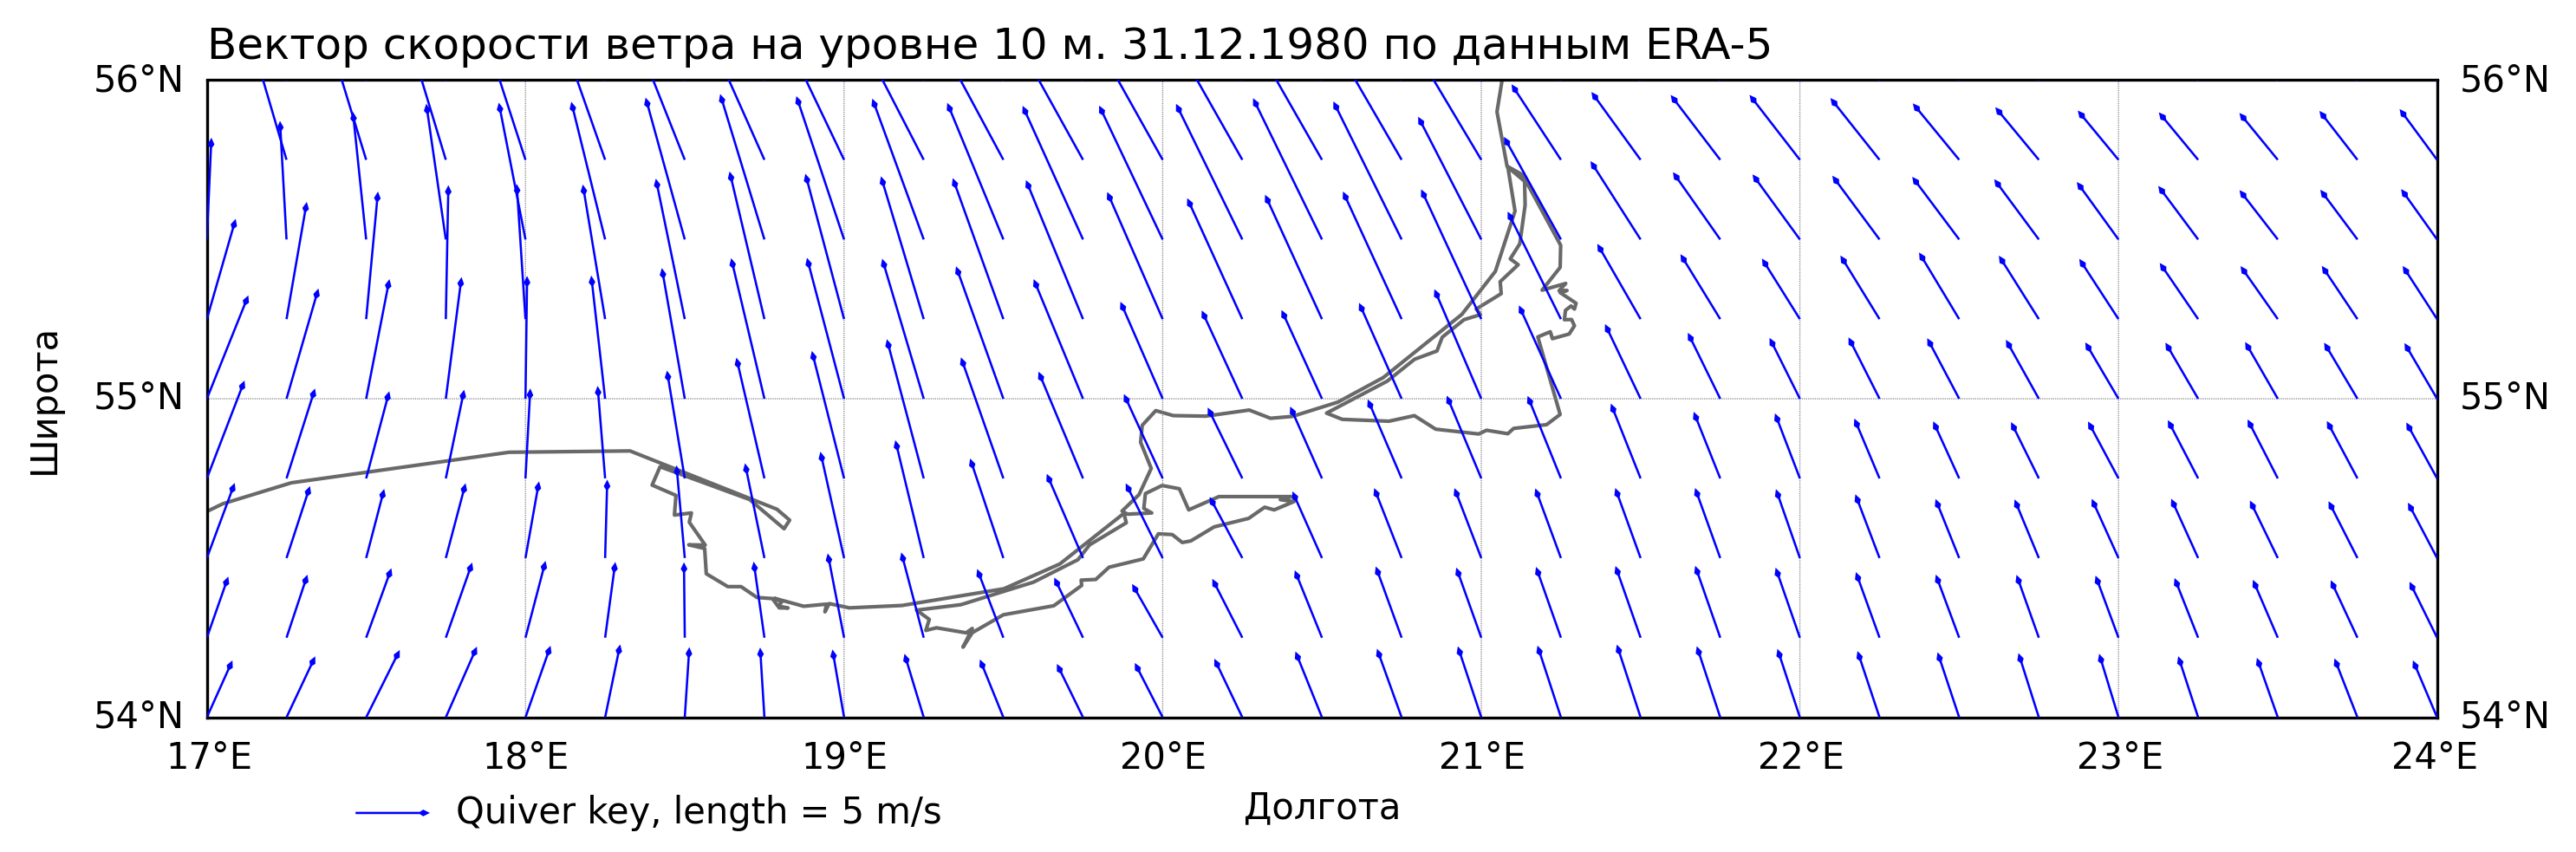

In [23]:
# Можно выбрать любой срок и посмотреть как меняется ветер, например, сравнить сроки 300 и 3500
# nlog номер срока 

nlog1=364
nlog2 = 1

fig=plt.figure(figsize=(10,6),dpi=300)

ax1=fig.add_subplot(1,1,1,label='1')

m1=Basemap(projection='cyl',ax=ax1,llcrnrlon=ll_lon,llcrnrlat=ll_lat,urcrnrlon=ur_lon,urcrnrlat=ur_lat,resolution='i')
x, y = m1(*np.meshgrid(lons, lats))

widths = np.linspace(0, 2, u10_daily_mean44.size)

q1=ax1.quiver(x, y, u10_daily[nlog1,:,:],v10_daily[nlog1,:,:],scale=150., zorder=3, color='blue',
          width=0.001, headwidth=3., headlength=3.)
# q2=ax1.quiver(x, y, u10_daily[nlog2,:,:],v10_daily[nlog2,:,:],scale=150., zorder=3, color='blue',
#           width=0.001, headwidth=3., headlength=3.)
ax1.quiverkey(q1, X=0.1, Y=-0.15, U=5,
             label='Quiver key, length = 5 m/s', labelpos='E')
# ax1.quiverkey(q2, X=0.1, Y=-0.15, U=5,
#              label='Quiver key, length = 5 m/s', labelpos='E')

ax1.set_xlabel('Долгота',labelpad=20,fontstretch= 'condensed')
ax1.set_ylabel('Широта',labelpad=40,fontstretch= 'condensed')
    
m1.drawcoastlines(color="dimgrey",linewidth=1)
meridians=np.arange(0,360,1)
parallels=np.arange(40,80,1)
    
m1.drawmeridians(meridians,color="grey",labels=[1, 1, 0, 1],linewidth=0.3)
m1.drawparallels(parallels,color="grey",labels=[1, 1, 0, 1],linewidth=0.3)

plt.title('Вектор скорости ветра на уровне 10 м. 31.12.1980 по данным ERA-5',loc='left')

plt.tight_layout()
#plt.savefig(inpath + 'region', fmt='png')

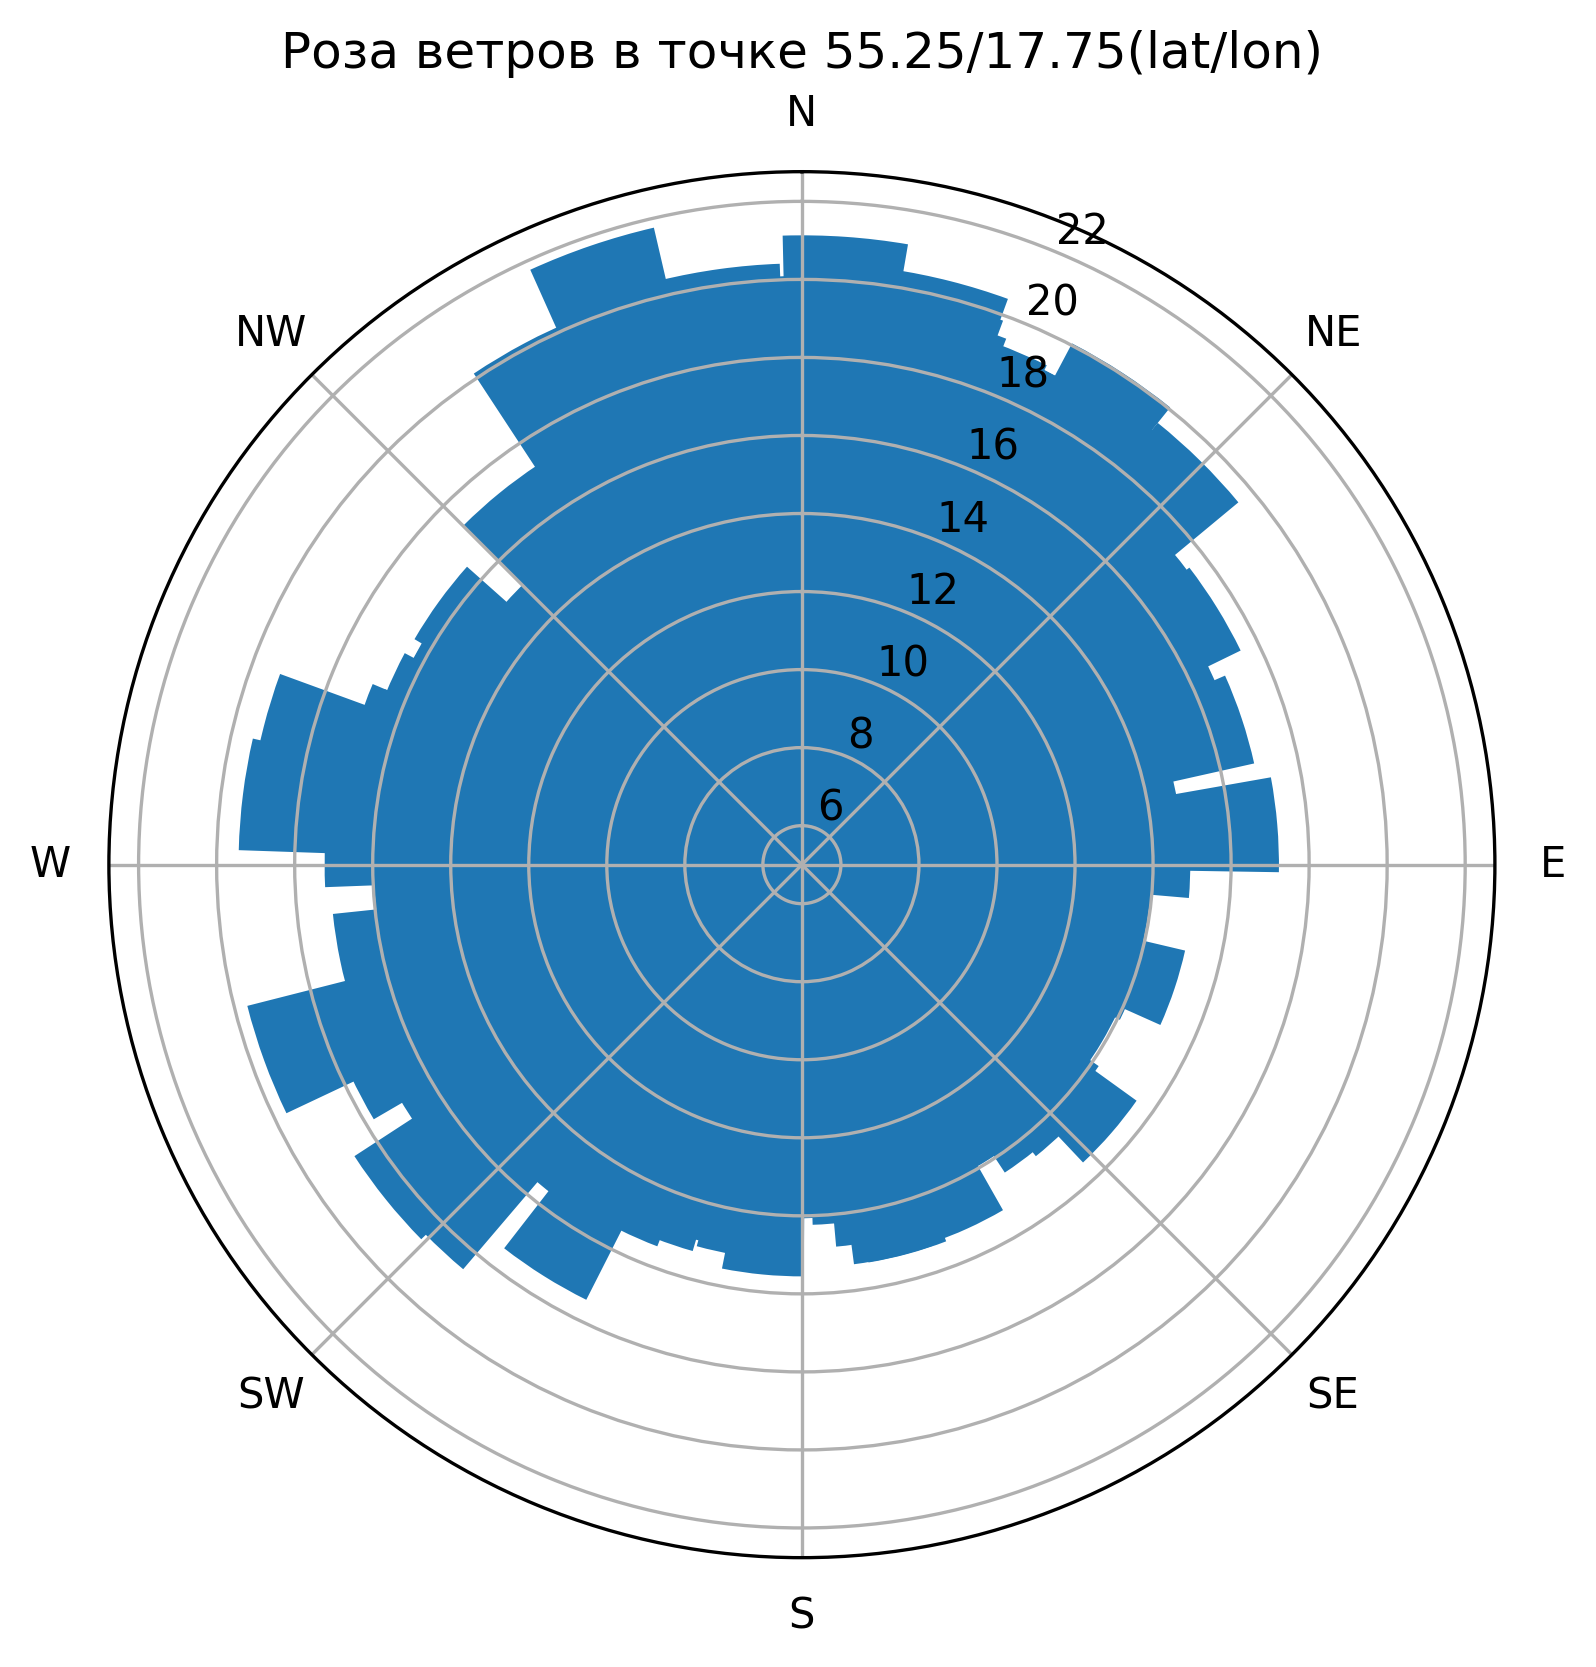

In [24]:
u = u10_daily[:, 3, 3]
v = v10_daily[:, 3, 3]

wind_speed = np.sqrt(u**2 + v**2)
wind_direction = (np.arctan2(v, u) * 180 / np.pi + 360) % 360

plt.figure(figsize=(6, 6), dpi=300)
ax = plt.subplot(111, polar=True)

# разделение на сектора
angles = np.linspace(0, 2 * np.pi, 36, endpoint=False)

bars = ax.bar(wind_direction * np.pi / 180, wind_speed, width=0.2, bottom=0.0)

ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")
ax.set_ylim(5, np.max(wind_speed) + 1)  # Установка максимальной высоты

# Добавление названий направлений
directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
ax.set_xticks(np.arange(0, 2*np.pi, 2*np.pi/8))
ax.set_xticklabels(directions)

plt.title("Роза ветров в точке 55.25/17.75(lat/lon)")
plt.show()


In [25]:
# Среднегодовые значения скорости ветра на уровне 10 м.

w10_yearly=np.empty([44,ilat,ilon])
w10_yearly=np.mean(w10_daily_y,axis=1)
w10_yearly[:,4,8]

array([7.22952718, 7.22813952, 7.27723197, 6.78845934, 7.85077834,
       7.17814081, 7.08883818, 7.53593833, 7.02983483, 7.32361539,
       7.37128387, 7.65642509, 7.14745065, 7.25628677, 7.50904427,
       7.32001374, 7.18392159, 6.58116438, 7.27635177, 7.44475691,
       6.88310481, 7.0762086 , 6.93698821, 7.12196825, 6.87187038,
       7.10772396, 6.79647547, 6.64763214, 7.29679578, 7.37179027,
       6.91735073, 6.82656156, 7.35469474, 7.10748318, 6.77364666,
       6.66675786, 7.36832758, 6.91447289, 7.3184048 , 6.54742493,
       7.26178708, 7.50471068, 7.07158   , 6.8323763 ])

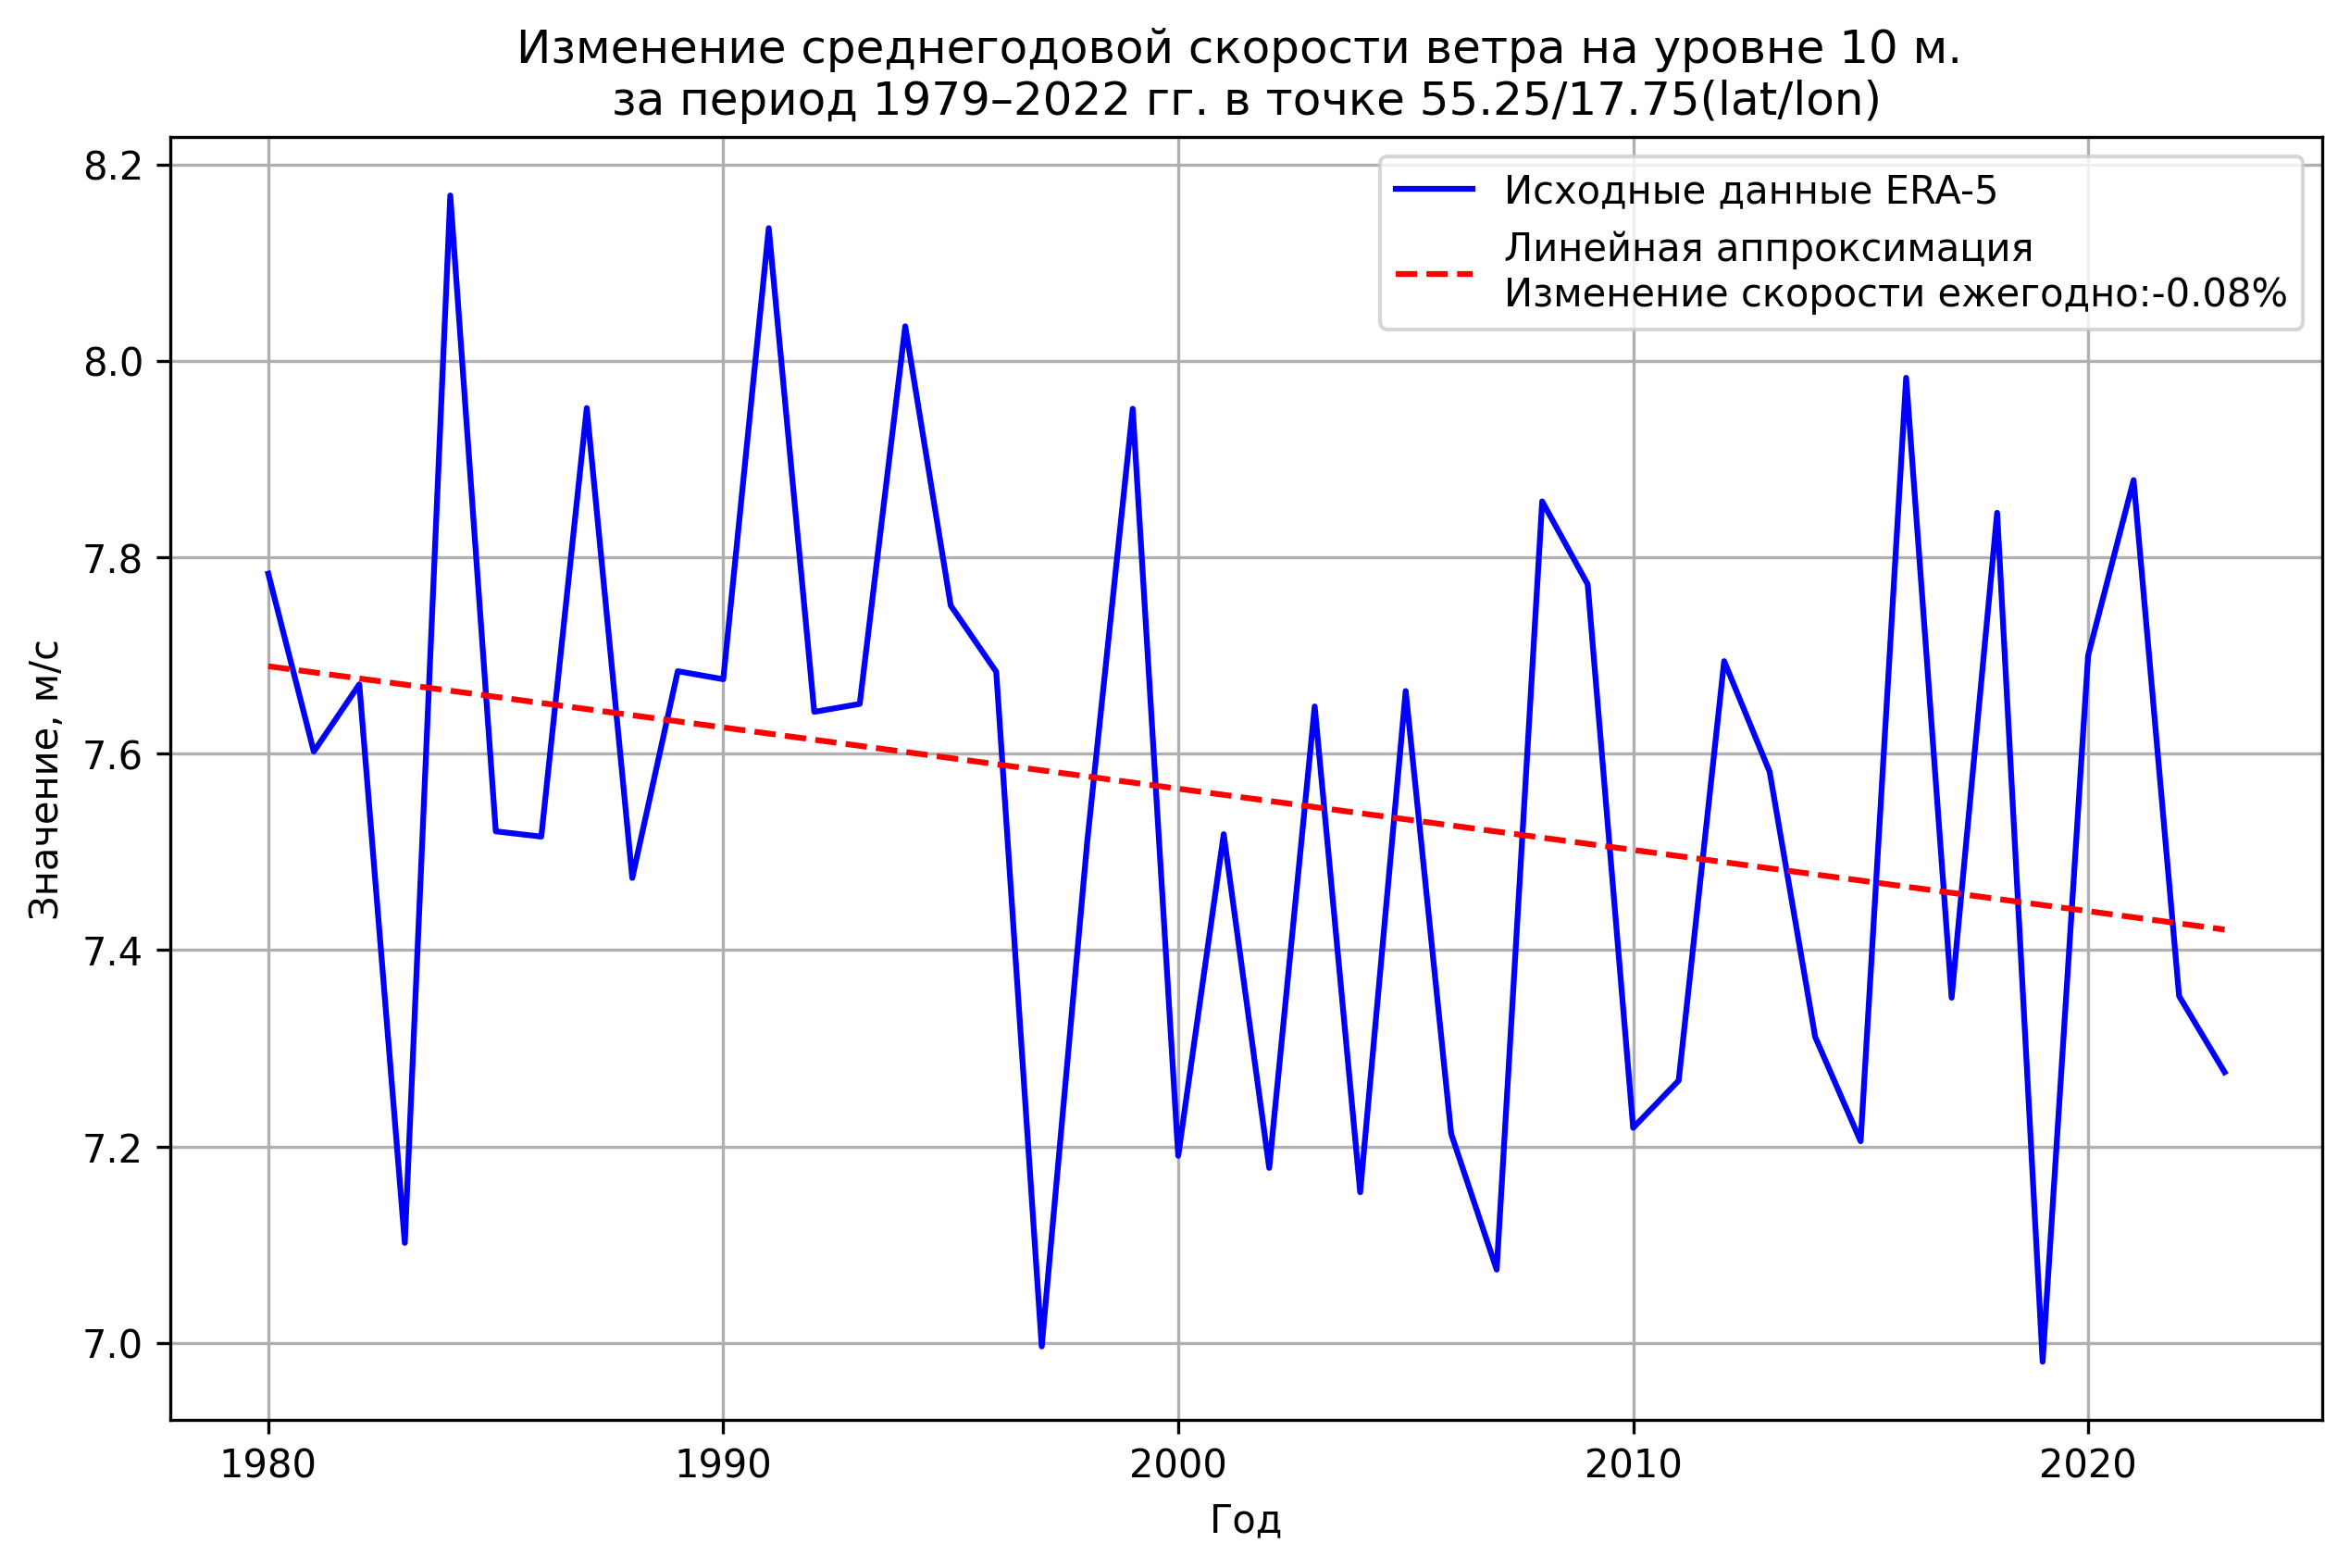

In [27]:
# Ваши данные
array_values = w10_yearly[:,3,3] 
time = np.arange(1980, 1980+44)

plt.figure(figsize=(10, 6), dpi=300)

# Построение линейного графика
plt.plot(time, array_values, color='blue', label='Исходные данные ERA-5')
plt.title('Изменение среднегодовой скорости ветра на уровне 10 м. \nза период 1979–2022 гг. в точке 55.25/17.75(lat/lon)')
plt.xlabel('Год')
plt.ylabel('Значение, м/с')
plt.grid(True) 

years = time[:-1]  # Годы, за исключением последнего


# мнк
slope, intercept = np.polyfit(time, array_values, 1)
linear_approximation = slope*time + intercept
percentage_change = np.diff(linear_approximation) / linear_approximation[:-1] * 100

plt.plot(time, linear_approximation, color='red', linestyle='dashed', label=f'Линейная аппроксимация \nИзменение скорости ежегодно:{percentage_change[0]:.2f}%')



plt.legend()
plt.show()

# # Вывод результатов
# for year, change in zip(years, percentage_change):
#     print(f'Процентное изменение между {year} и {year+1}: {change:.2f}%')


In [28]:
# Расчет линейного тренда для среднегодовых значений

l_tr=np.empty([2])
tr_w10_daily=np.empty([2,ilat,ilon])
for j in range(ilat):
    for i in range(ilon):
        l_tr[1], l_tr[0] = np.polyfit(range(0,44),w10_yearly[:,j,i],1)
        tr_w10_daily[1,j,i]=l_tr[1]
        tr_w10_daily[0,j,i]=l_tr[0]

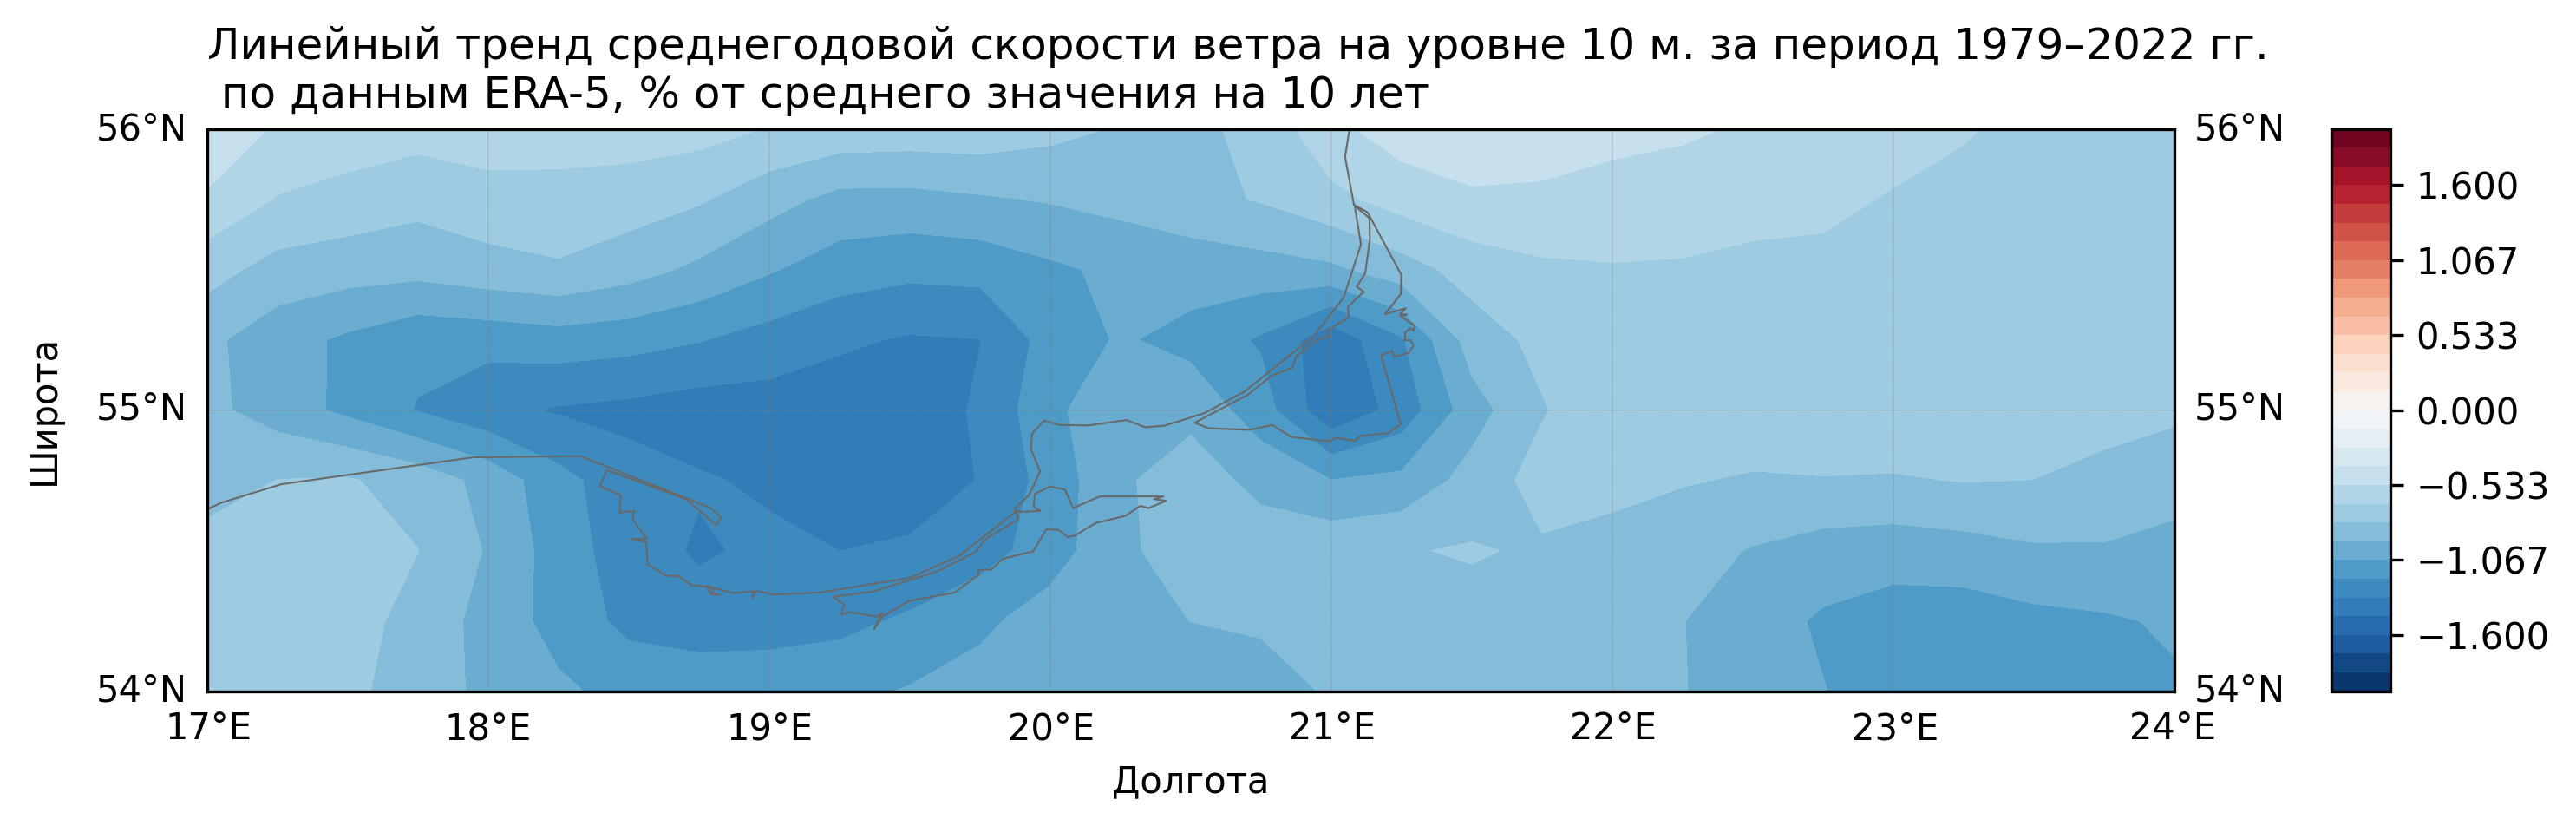

In [29]:
# Линейный тренд среднегодовой скорости ветра на уровне 10 м.

xsc_lt_lat=[55,55]
ysc_lt_lon=[19,21]

clevs = np.linspace(-2,2,31)
fig=plt.figure(figsize=(10,6),dpi=300)

ax1=fig.add_subplot(1,1,1,label='1')

m1=Basemap(projection='cyl',ax=ax1,llcrnrlon=ll_lon,llcrnrlat=ll_lat,urcrnrlon=ur_lon,urcrnrlat=ur_lat,resolution='i')
x, y = m1(*np.meshgrid(lons, lats))
cs=m1.contourf(x, y,tr_w10_daily[1,:,:]*1000/np.mean(w10_yearly),clevs,cmap=plt.cm.RdBu_r)

# ax1.scatter(ysc_lt_lon, xsc_lt_lat,100,marker='o',color='k')

    
m1.drawcoastlines(color="dimgrey",linewidth=0.5)
meridians=np.arange(0,360,1)
parallels=np.arange(40,90,1)
    
m1.drawmeridians(meridians,color="grey",labels=[1, 1, 0, 1],linewidth=0.2)
m1.drawparallels(parallels,color="grey",linewidth=0.2,labels=[1, 1, 1, 1])

ax1.set_xlabel('Долгота',labelpad=20,fontstretch= 'condensed')
ax1.set_ylabel('Широта',labelpad=40,fontstretch= 'condensed')

m1.colorbar(cs,location='right',size='3%',pad='8%')

plt.title('Линейный тренд среднегодовой скорости ветра на уровне 10 м. за период 1979–2022 гг. \n по данным ERA-5, % от среднего значения на 10 лет',loc='left')

plt.tight_layout()
#plt.savefig(inpath + 'region', fmt='png')

In [30]:
w10_yearly.shape

(44, 9, 29)

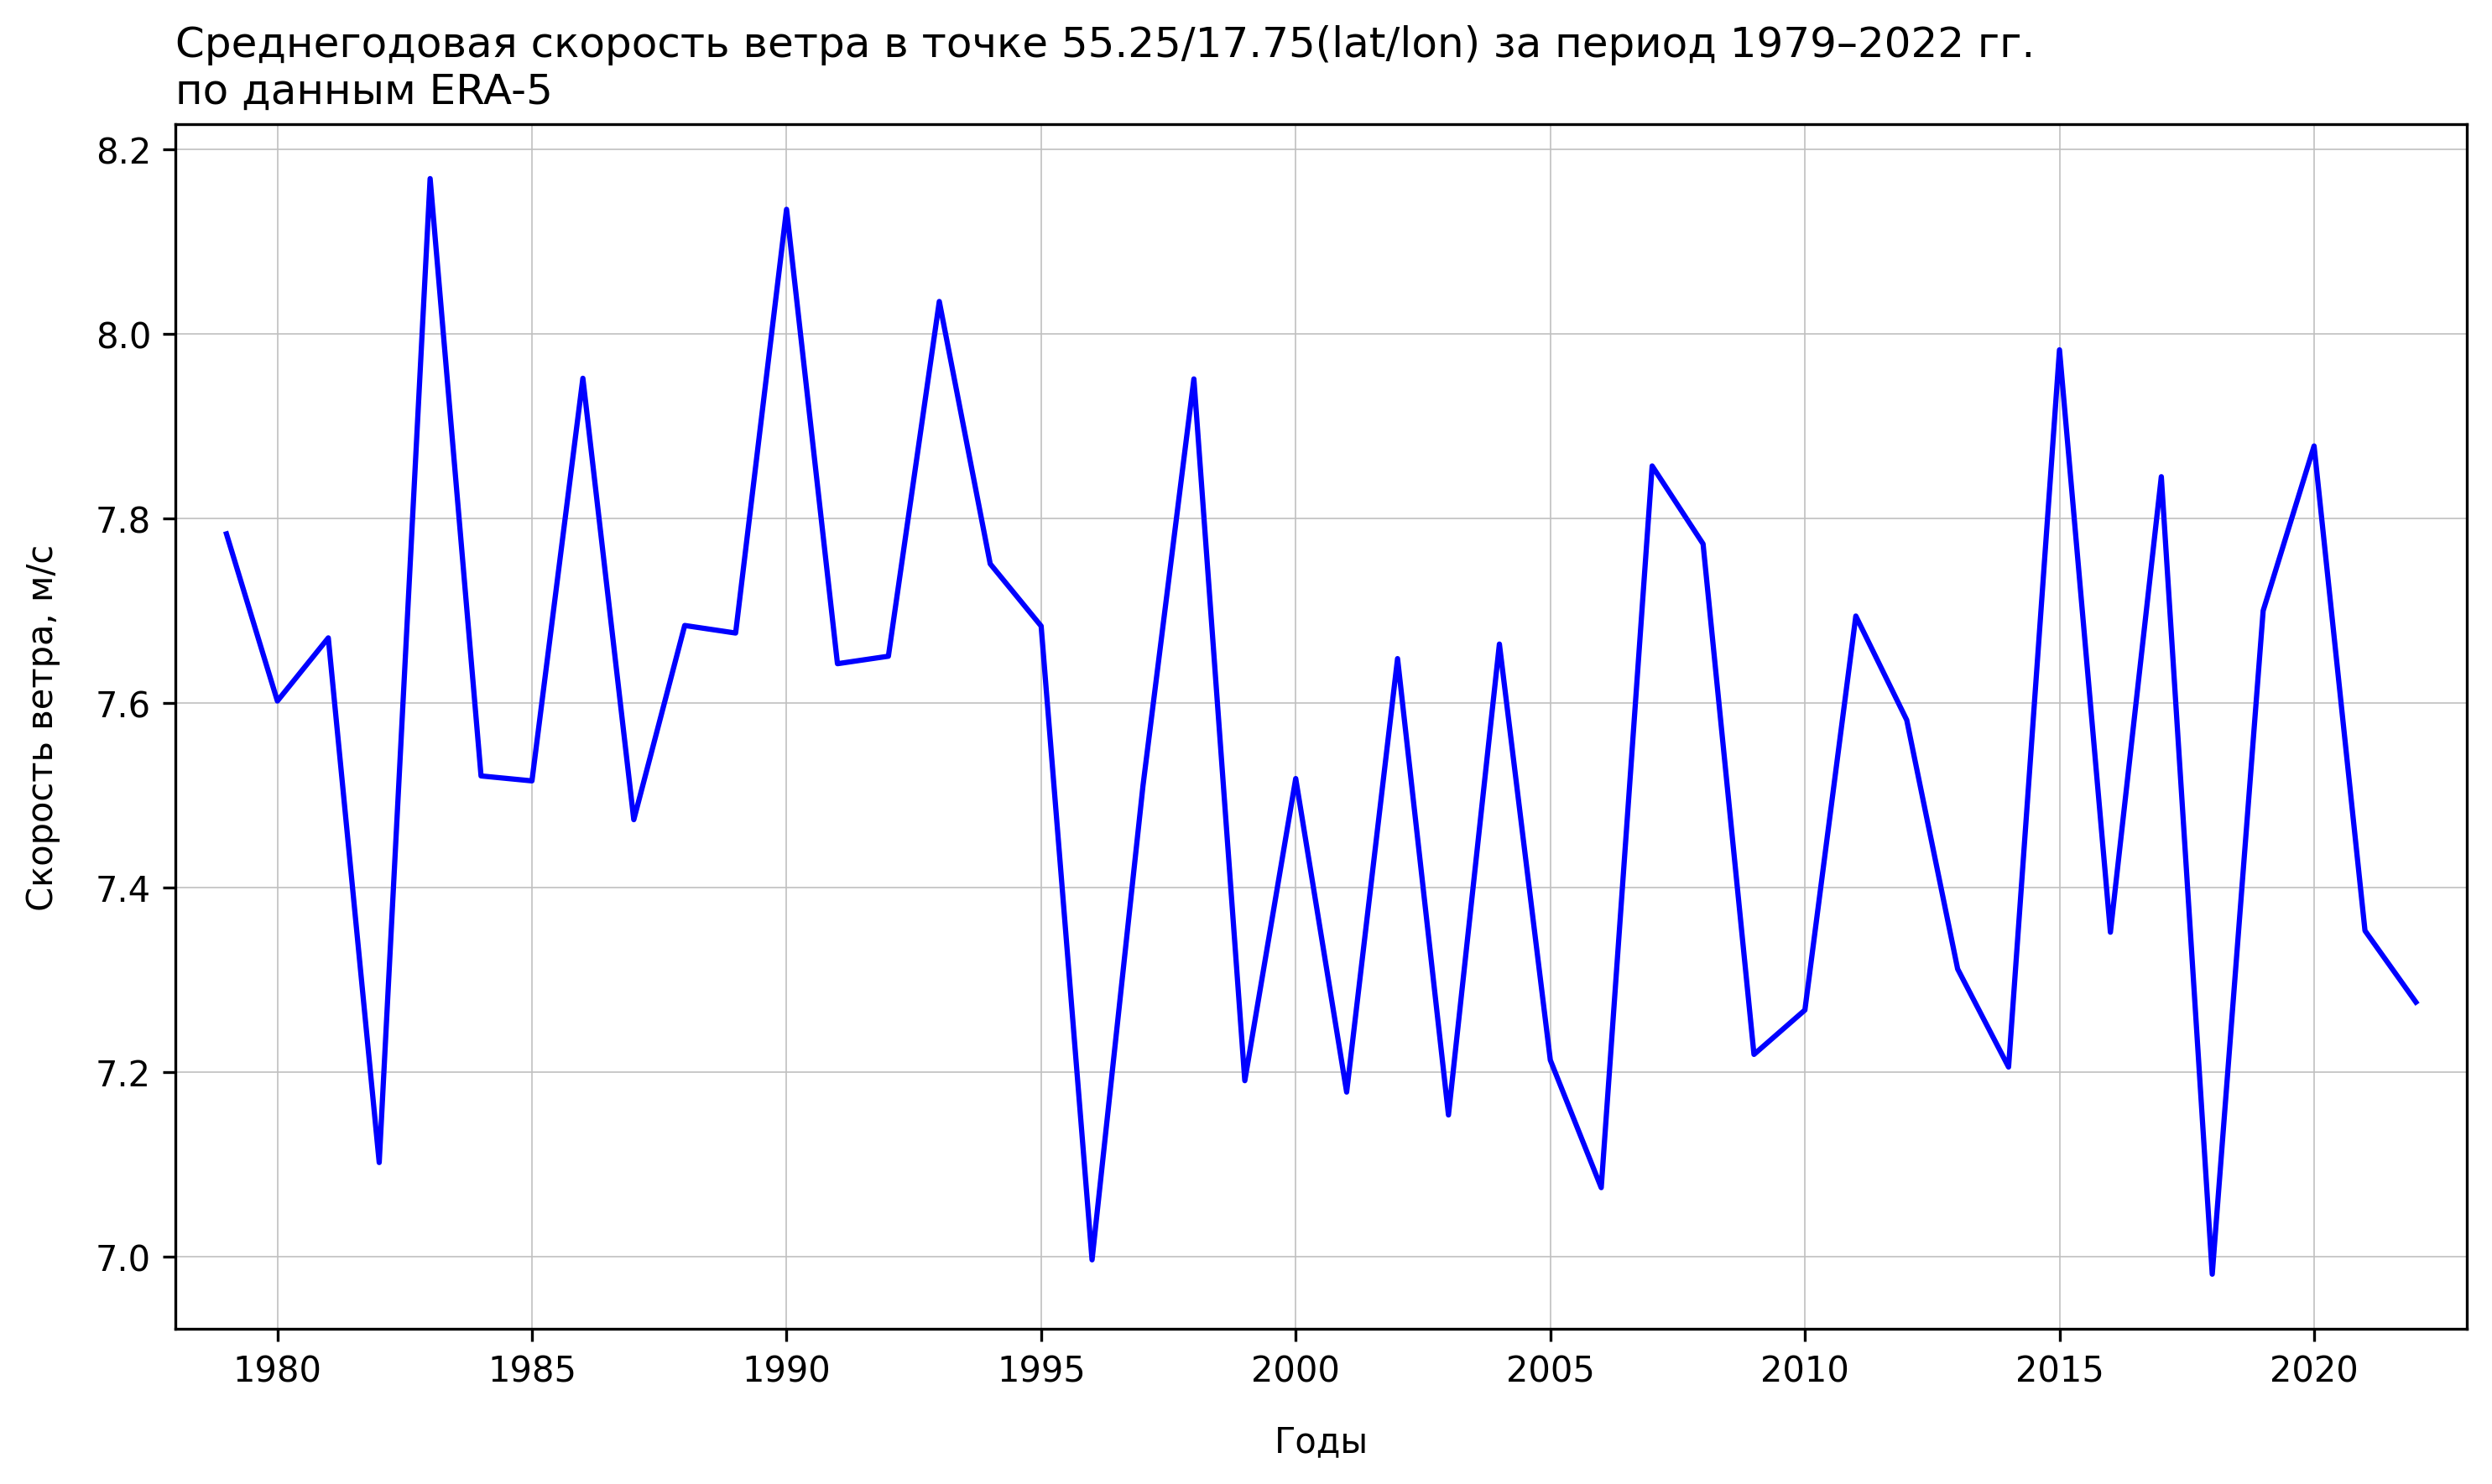

In [31]:
# Выбрать точку для построения временной изменчивости. ylon=(lon-17)*4, xlat=(56-lat)*4

ylon=3
xlat=3

fig=plt.figure(figsize=(10,6),dpi=300)
ax1=fig.add_subplot(1,1,1,label='1')



plt.plot(np.asarray([k for k in range(1979,2023,1)]),w10_yearly[:,xlat,ylon],color='blue')

ax1.set_xlabel('Годы',labelpad=10,fontstretch= 'condensed')
ax1.set_ylabel('Скорость ветра, м/с',labelpad=10,fontstretch= 'condensed')

#ax1.set_ylim(6,7.5)
ax1.set_xlim(1978,2023)

ax1.grid(linewidth=0.4,color='silver')

plt.title('Среднегодовая скорость ветра в точке 55.25/17.75(lat/lon) за период 1979–2022 гг. \nпо данным ERA-5',loc='left')

plt.tight_layout()
# plt.savefig(inpath + 'region', fmt='png')


In [32]:
w10_yy_mean=np.mean(w10_daily_y,axis=0)
w10_yy_mean.shape

(365, 9, 29)

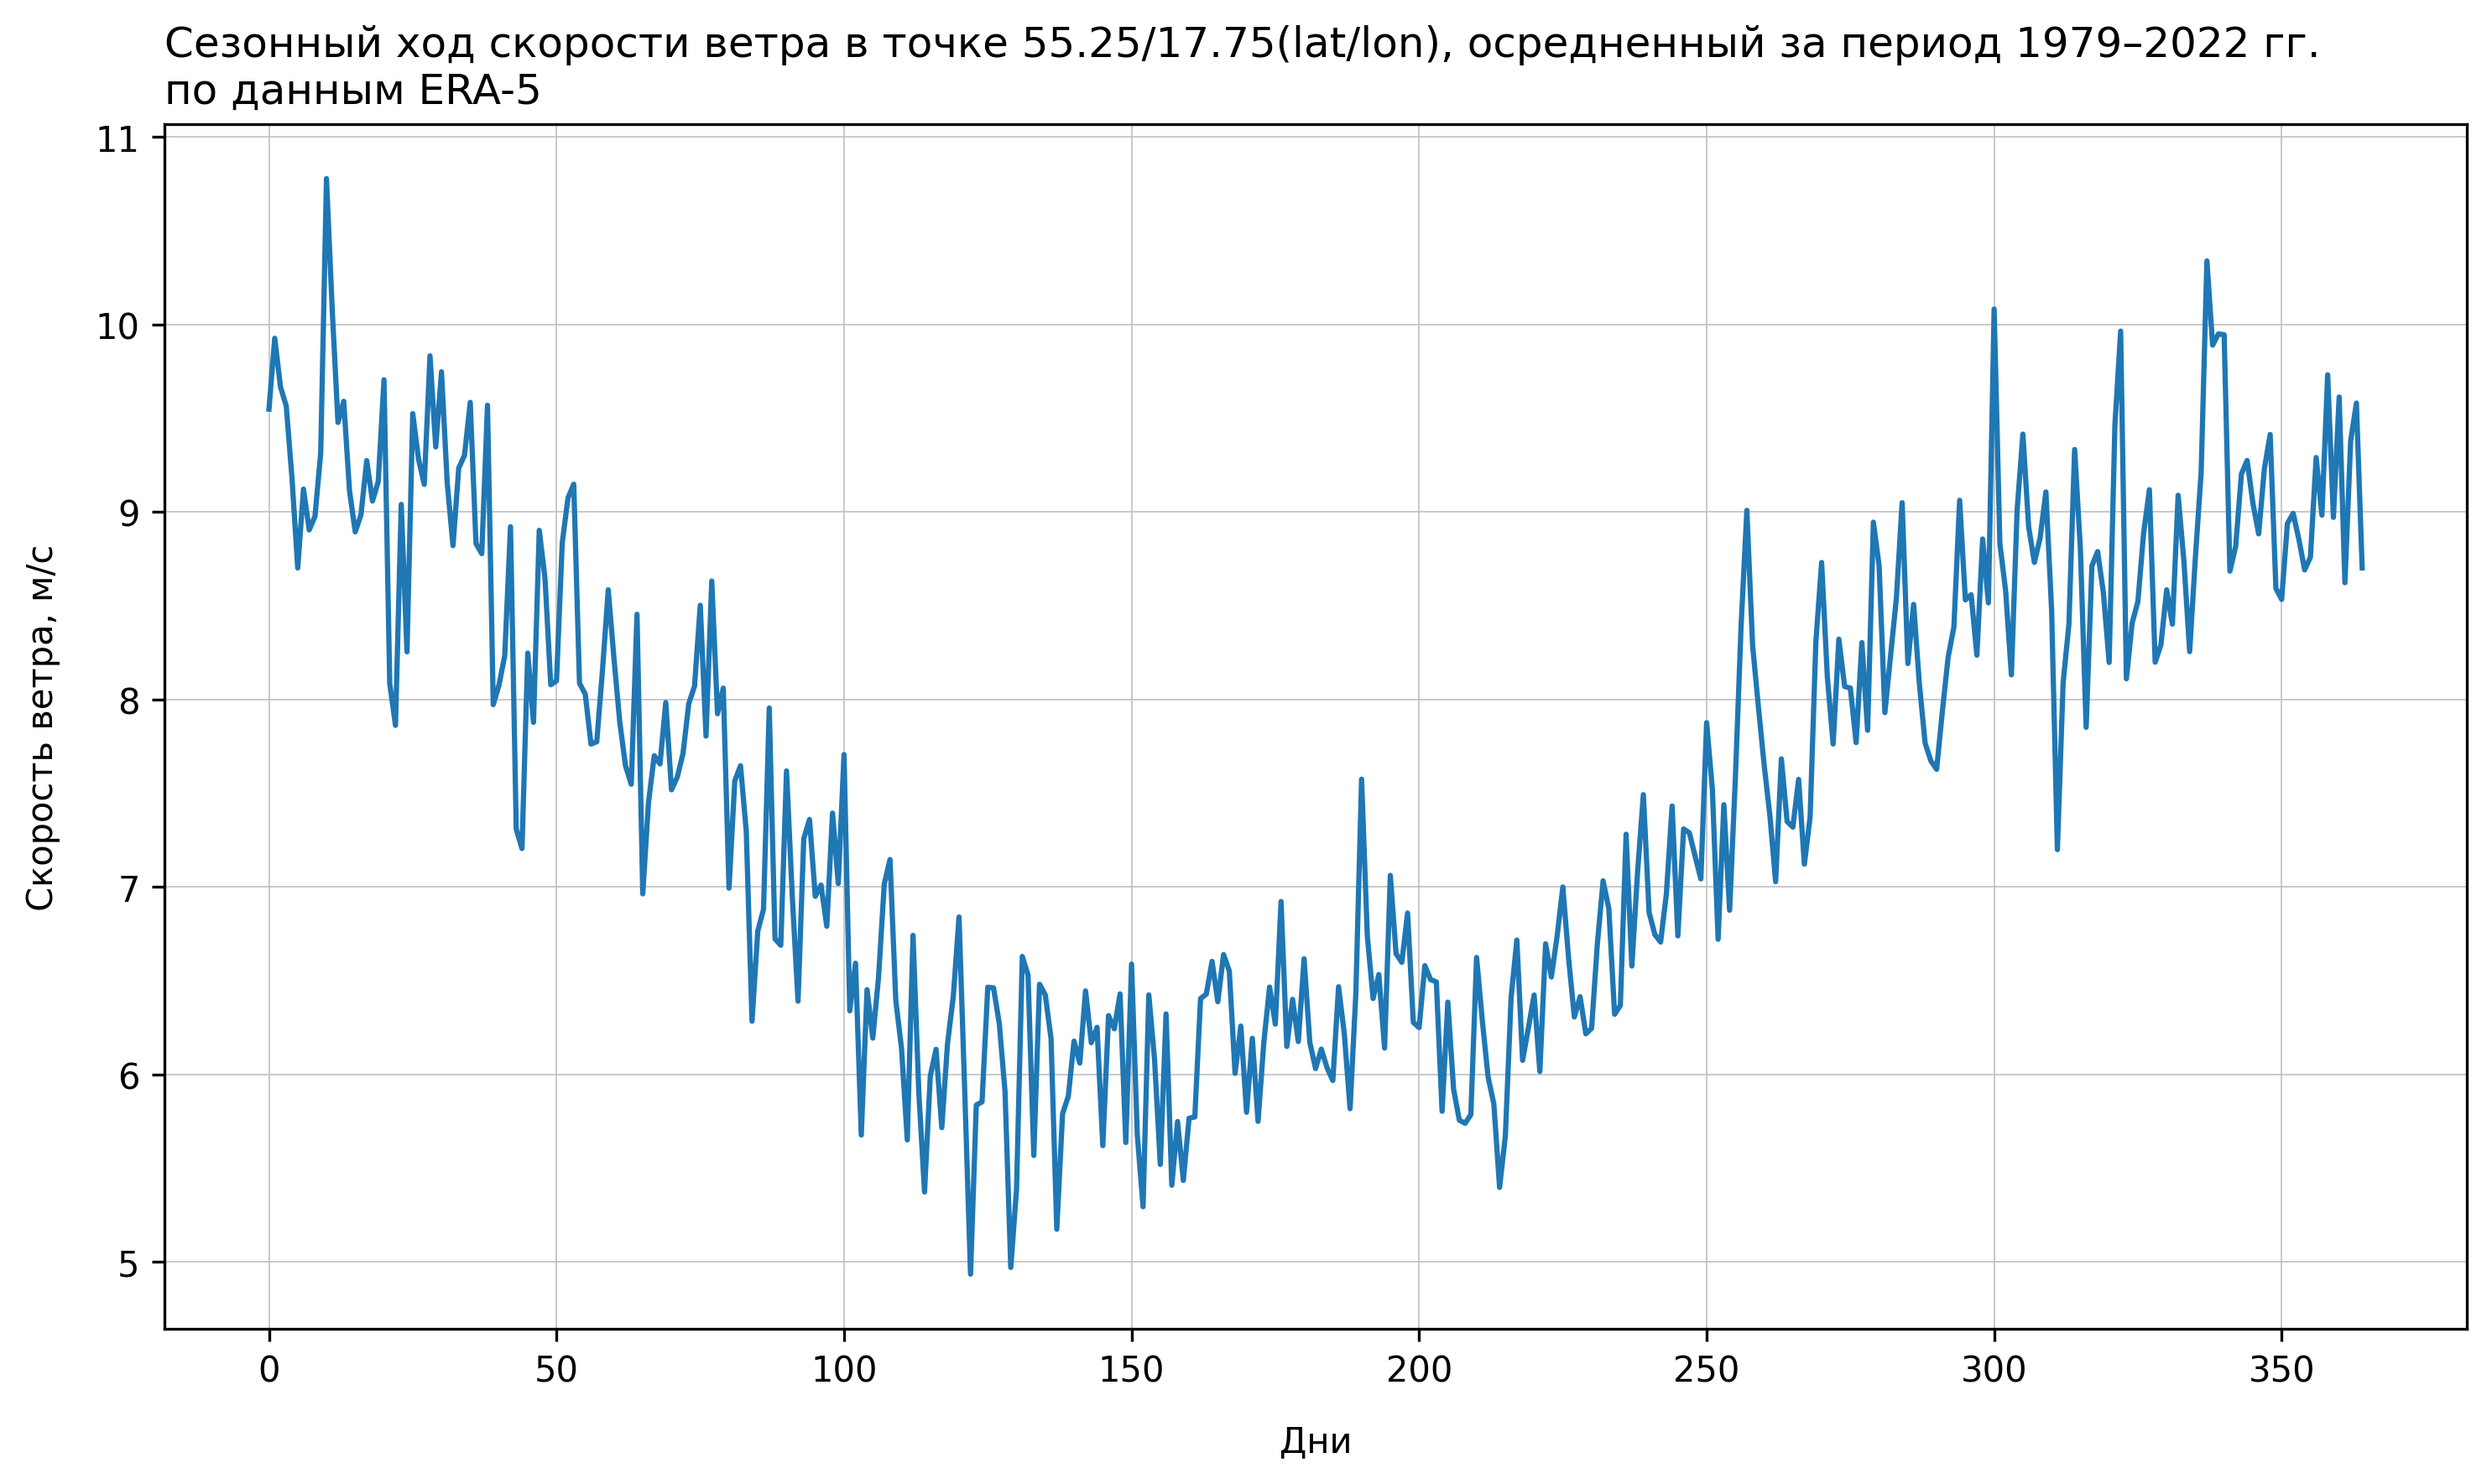

In [33]:
# Сезонный ход скорости ветра в выбранной точке

slon=3
slat=3

days=np.asarray([k for k in range(0,365,1)])
fig1 = plt.figure(figsize=(10,6),dpi=300)

ax1=fig1.add_subplot(1,1,1,label='1')

ax1.plot(days,w10_yy_mean[:,slat,slon])

ax1.set_xlabel('Дни',labelpad=10,fontstretch= 'condensed')
ax1.set_ylabel('Скорость ветра, м/с',labelpad=10,fontstretch= 'condensed')

#ax1.set_ylim(6,7.5)
#ax1.set_xlim(1978,2023)

ax1.grid(linewidth=0.4,color='silver')

plt.title('Сезонный ход скорости ветра в точке 55.25/17.75(lat/lon), осредненный за период 1979–2022 гг. \nпо данным ERA-5',loc='left')

plt.tight_layout()
#plt.savefig(inpath + 'region', fmt='png')


In [34]:
# Выборка данных по сезону

dat_sp=np.empty([4048,9,29])
dat_sm=np.empty([4048,9,29])
dat_au=np.empty([4004,9,29])
dat_wn=np.empty([3960,9,29])

for ii in range(0,ilon,1):
    for jj in range(0,ilat,1):
        for i in range(0,44,1):
            for d in range(59,150,1):
                dat_sp[i*92+(d-59),jj,ii]=w10_daily_y[i,d,jj,ii]
            for d in range(151,242,1):
                dat_sm[i*92+(d-151),jj,ii]=w10_daily_y[i,d,jj,ii]
            for d in range(243,333,1):
                dat_au[i*91+(d-243),jj,ii]=w10_daily_y[i,d,jj,ii]
            for d in range(0,59,1):
                dat_wn[i*90+d,jj,ii]=w10_daily_y[i,d,jj,ii]
            for d in range(334,364,1):
                dat_wn[i*(90)+59+(d-334),jj,ii]=w10_daily_y[i,d,jj,ii]
        

In [35]:
# Выбор точки для оценки непрерывности работы систем

lon_ind=3
lat_ind=3

box_dat=[]
box_num=[]

box_dat.append(dat_wn[:,lat_ind,lon_ind])
box_num.append(len(dat_wn))
box_dat.append(dat_sp[:,lat_ind,lon_ind])
box_num.append(len(dat_sp))
box_dat.append(dat_sm[:,lat_ind,lon_ind])
box_num.append(len(dat_sm))
box_dat.append(dat_au[:,lat_ind,lon_ind])
box_num.append(len(dat_au))

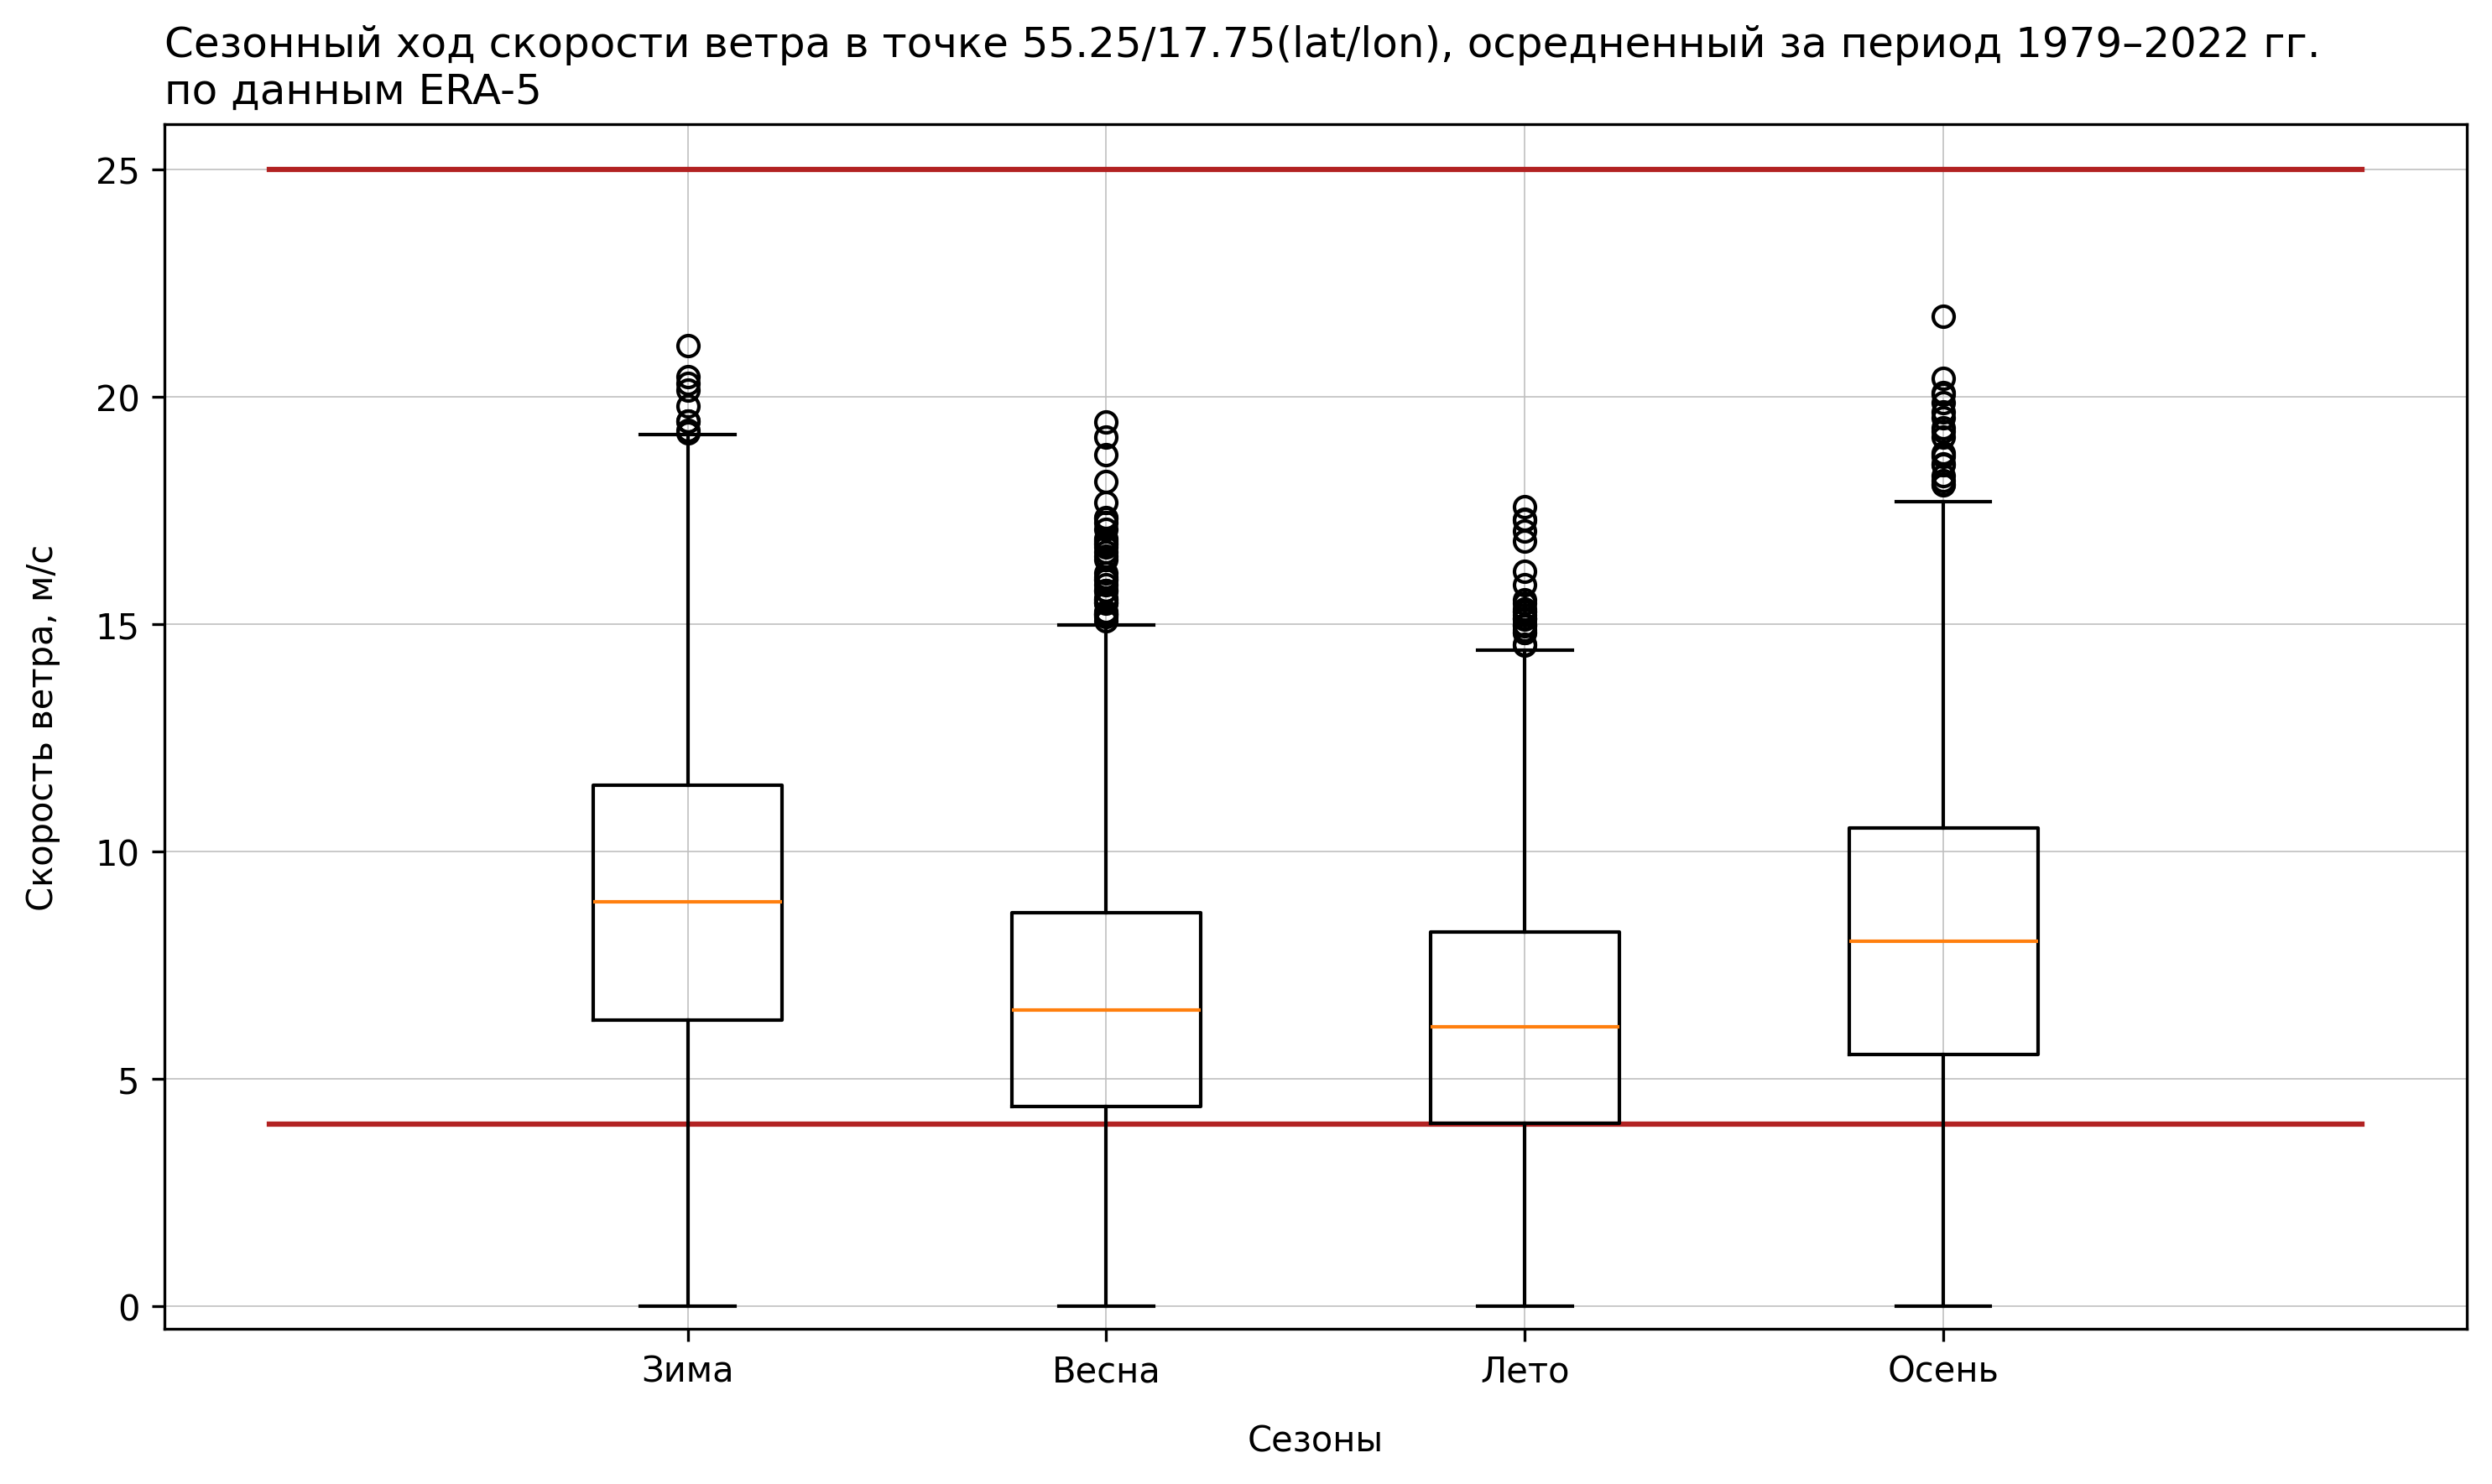

In [37]:
fig1 = plt.figure(figsize=(10,6),dpi=300)

ax1=fig1.add_subplot(111, label="1",)

ax1.boxplot([np.array([box_dat[k][i] for i in range(box_num[k])]) for k in range(4)],
            zorder=4, positions=[i for i in range(1,5)])
ax1.plot([0,5],[4,4],color='firebrick')
ax1.plot([0,5],[25,25],color='firebrick')

ax1.set_xlabel('Сезоны',labelpad=10,fontstretch= 'condensed')
ax1.set_ylabel('Скорость ветра, м/с',labelpad=10,fontstretch= 'condensed')

ax1.set_ylim(-0.5,26)
# ax1.set_xlim(-1,6)

# ax1.set_xlim(1978,2023)

ax1.set_xticks((1,2,3,4))
ax1.set_xticklabels(('Зима','Весна','Лето','Осень'))

ax1.grid(linewidth=0.4,color='silver')

plt.title('Сезонный ход скорости ветра в точке 55.25/17.75(lat/lon), осредненный за период 1979–2022 гг. \nпо данным ERA-5',loc='left')

plt.tight_layout()
#plt.savefig(inpath + 'region', fmt='png')


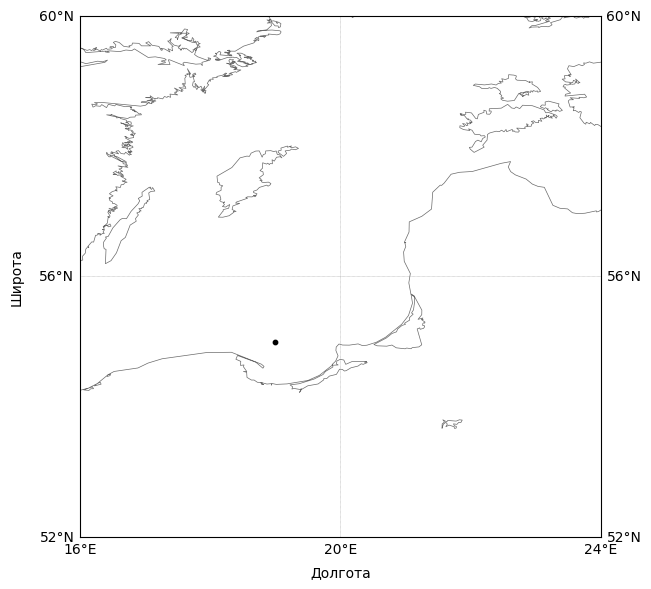

In [38]:
# Регион исследования "Калининградская область"
# 17–24E, 54–56N

fig=plt.figure(figsize=(7,6),dpi=100)

ax1=fig.add_subplot(1,1,1,label='1')

m1=Basemap(ax=ax1,projection='cyl',llcrnrlon=16,llcrnrlat=52,urcrnrlon=24,urcrnrlat=60,resolution='i')

# x9,y9 = m1(ll_lon,54)
# x10,y10 = m1(ur_lon,54)
# x11,y11 = m1(ur_lon,56)
# x12,y12 = m1(ll_lon,56)
# poly = Polygon([(x9,y9),(x10,y10),(x11,y11),(x12,y12)],facecolor='None',edgecolor='tab:red',linewidth=3)
# plt.gca().add_patch(poly)

m1.drawcoastlines(color="dimgrey",linewidth=0.5)
# meridians=np.arange(0,360,20)
# parallels=np.arange(40,90,10)
meridians=np.arange(0,360,4)
parallels=np.arange(40,90,4)

ax1.set_xlabel('Долгота',labelpad=20,fontstretch= 'condensed')
ax1.set_ylabel('Широта',labelpad=40,fontstretch= 'condensed')

    
m1.drawmeridians(meridians,color="grey",labels=[0, 0, 0, 1],linewidth=0.3)
m1.drawparallels(parallels,color="grey",labels=[1, 1, 0, 1],linewidth=0.3)
ax1.scatter(19, 55,10,marker='o',color='k')


# plt.title('Регион оценки потенциала оффшорной ветровой энергетики',loc='left')

plt.tight_layout()
#plt.savefig(inpath + 'region', fmt='png')

In [39]:
# Расчет штилевых и штормовых дней
# Выбор точки для оценки непрерывности работы систем 

lon_ind=3
lat_ind=3

stil_wn=0
storm_wn=0

for i in range(len(dat_wn)):
    if dat_wn[i,lat_ind,lon_ind] < 4:
        stil_wn=stil_wn+1
    if dat_wn[i,lat_ind,lon_ind] >25:
        storm_wn=storm_wn+1
        
out_stil=stil_wn*100/len(dat_wn)
out_storm=storm_wn*100/len(dat_wn)

In [40]:
# Расчет штилевых и штормовых дней в % от общего кол-ва дней за период наблюдений

print('Штилевые условия в ', round(out_stil, 2),'% дней за период наблюдений (меньше 4 м/с)') 
print('Штормовые условия в ', out_storm,'% дней за период наблюдений (больше 25 м/с)')

Штилевые условия в  10.23 % дней за период наблюдений (меньше 4 м/с)
Штормовые условия в  0.0 % дней за период наблюдений (больше 25 м/с)


In [41]:
print(np.max(w10_daily_y), np.min(w10_daily_y), w10_daily_y.shape) 
print(np.max(w10_daily_y[:, :, 3,3]), np.min(w10_daily_y), w10_daily_y.shape) 


22.462106704711914 0.002790949773043394 (44, 365, 9, 29)
21.76143455505371 0.002790949773043394 (44, 365, 9, 29)


In [42]:
ro=1.2255
pi=3.14
D=125

P=0.45*ro*pi*(D**2)*w10_daily_y**3/(8*(10**(6)))

P_ymean=np.mean(P, axis=0)
print(np.max(P_ymean), P_ymean.shape)

5.659103278662977 (365, 9, 29)


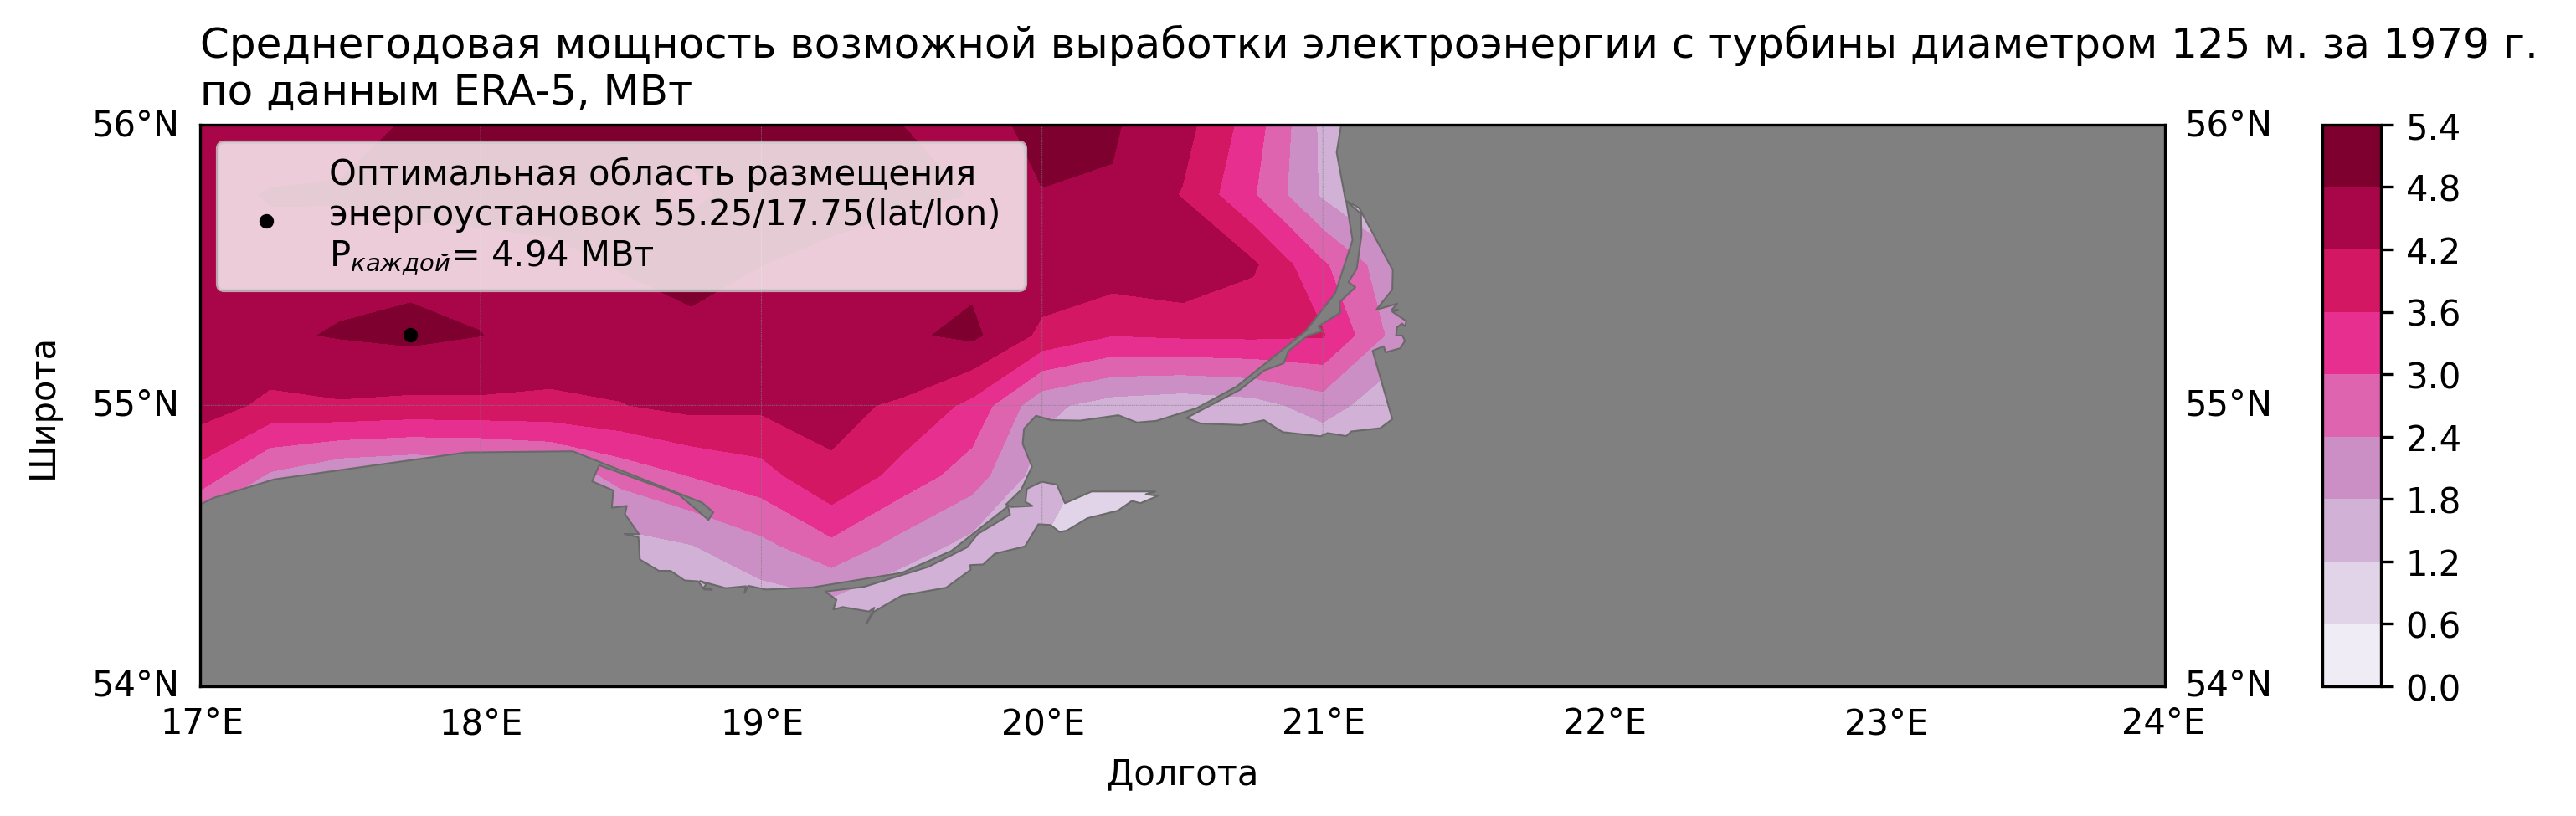

In [43]:
clevs = np.linspace(0,0.6,20)

fig=plt.figure(figsize=(10,6),dpi=300)

ax1=fig.add_subplot(1,1,1,label='1')

m1=Basemap(projection='cyl',ax=ax1,llcrnrlon=ll_lon,llcrnrlat=ll_lat,urcrnrlon=ur_lon,urcrnrlat=ur_lat,resolution='i')
x, y = m1(*np.meshgrid(lons, lats))
cs=m1.contourf(x, y,P_ymean[1,:,:],cmap=plt.cm.PuRd)
    
m1.drawcoastlines(color="dimgrey",linewidth=0.5)
meridians=np.arange(0,360,1)
parallels=np.arange(40,90,1)
m1.fillcontinents(color='gray')
    
m1.drawmeridians(meridians,color="grey",labels=[1, 1, 0, 1],linewidth=0.2)
m1.drawparallels(parallels,color="grey",linewidth=0.2,labels=[1, 1, 1, 1])

ax1.set_xlabel('Долгота',labelpad=20,fontstretch= 'condensed')
ax1.set_ylabel('Широта',labelpad=40,fontstretch= 'condensed')
ax1.scatter(17.75, 55.25, 10,marker='o',color='k', label='Оптимальная область размещения\nэнергоустановок 55.25/17.75(lat/lon) \nP$_{каждой}$'+ f'= {P_ymean[1,3,3]:.2f} МВт')
plt.legend()

m1.colorbar(cs,location='right',size='3%',pad='8%')
plt.title('Среднегодовая мощность возможной выработки электроэнергии с турбины диаметром 125 м. за 1979 г. \nпо данным ERA-5, МВт',loc='left')


plt.tight_layout()
#plt.savefig(inpath + 'region', fmt='png')



In [44]:
P_ymean[1,3,3]

4.93965250761535